**Imports**

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import saraRC1 as sara
import saraRC1Old as sara_old

seg_dim = 9

BATCH_SIZE = 4

**Multi-Plot**

In [2]:
# ranges = list(zip(np.arange(1, 7000, 500), np.arange(500, 7100, 500)))
ranges = list(zip(np.arange(0, 2501, 500), np.arange(500, 2501, 500)))
ranges = [list(t) for t in ranges]
ranges[0][0] = 0
# ranges[0][1] = 50

In [3]:
img_path = './ASSR/images/test/'
imgs = {}

i = 0
experiment = 1
range_ = ranges[experiment - 1]

for root, dirs, files in os.walk(img_path):
    for file in files[range_[0]:range_[1]]:
        file_name = file.split('.')[0]
        imgs[file_name] = cv2.cvtColor(cv2.imread(os.path.join(root, file)), cv2.COLOR_BGR2RGB)
        i += 1

In [4]:
mask_path = './ASSR/gt/test/'
# masks = {}
gt_masks = {}
gt_ranks = {}

for file_name in imgs:
    gt_ranks[file_name] = {}
    
    file = file_name + '.png'
    mask = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
    # masks[file_name] = cv2.cvtColor(cv2.imread(os.path.join(mask_path, file)), cv2.COLOR_BGR2GRAY)
    # Separate the mask based on colour
    # masks[file_name] = {}
    gt_masks[file_name] = {}

    # Detect different colours in mask
    # Create histogram
    hist = cv2.calcHist([mask], [0], None, [256], [0, 256])

    # Show non-zero values and extract intensity values at that freq
    non_zero = np.nonzero(hist)
    x = non_zero[0][1:]

    # Separate mask into regions which match the intensity values in x
    for i, intensity in enumerate(reversed(x)):
        # masks[file_name][i] = np.where(mask == intensity, 1, 0)
        gt_masks[file_name][i] = np.where(mask == intensity, 1, 0)
        
        # Calculate ranks based on highest intensity
        gt_ranks[file_name][i] = i + 1


**MASK R-CNN**

In [5]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnntf2 import utils
import mrcnntf2.model as modellib
from mrcnntf2 import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [6]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = BATCH_SIZE
    GPU_IDS = "0"

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GPU_IDS                        0
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

In [7]:
import tensorflow as tf
import keras
import h5py
print(tf.__version__)
print(keras.__version__)
print(h5py.__version__)

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)


# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

2.6.2
2.6.0
3.1.0
Instructions for updating:
Use fn_output_signature instead


In [8]:
# Split the images into batches
image_batches = [list(imgs.values())[i:i+BATCH_SIZE] for i in range(0, len(imgs), BATCH_SIZE)]


masks = {}
i = 0

for batch in image_batches:
    # Run detection for the current batch
    results = model.detect(batch, verbose=0)
    
    # Process the results for the batch
    for result in results:
        file_name = list(imgs.keys())[i]
        
        # Visualize results for the current image in the batch
        r = result
        # visualize.display_instances(imgs[file_name], r['rois'], r['masks'], r['class_ids'], 
        #                             class_names, r['scores'])

        masks[file_name] = {}

        for j in range(len(r['class_ids'])):
            masks[file_name][j] = np.array(r['masks'][:, :, j], dtype=np.uint8) * 255


        i += 1


    # Print progress
    print(f'Batch {i // BATCH_SIZE} of {len(imgs) // BATCH_SIZE} complete')

Batch 1 of 125 complete
Batch 2 of 125 complete
Batch 3 of 125 complete
Batch 4 of 125 complete
Batch 5 of 125 complete
Batch 6 of 125 complete
Batch 7 of 125 complete
Batch 8 of 125 complete
Batch 9 of 125 complete
Batch 10 of 125 complete
Batch 11 of 125 complete
Batch 12 of 125 complete
Batch 13 of 125 complete
Batch 14 of 125 complete
Batch 15 of 125 complete
Batch 16 of 125 complete
Batch 17 of 125 complete
Batch 18 of 125 complete
Batch 19 of 125 complete
Batch 20 of 125 complete
Batch 21 of 125 complete
Batch 22 of 125 complete
Batch 23 of 125 complete
Batch 24 of 125 complete
Batch 25 of 125 complete
Batch 26 of 125 complete
Batch 27 of 125 complete
Batch 28 of 125 complete
Batch 29 of 125 complete
Batch 30 of 125 complete
Batch 31 of 125 complete
Batch 32 of 125 complete
Batch 33 of 125 complete
Batch 34 of 125 complete
Batch 35 of 125 complete
Batch 36 of 125 complete
Batch 37 of 125 complete
Batch 38 of 125 complete
Batch 39 of 125 complete
Batch 40 of 125 complete
Batch 41 

In [9]:
# Match masks generated by Mask RCNN to ground truth masks

masks_valid = {}
gt_masks_valid = {}
gt_ranks_valid = {}

for file_name in masks:
    masks_valid[file_name] = {}
    gt_masks_valid[file_name] = {}
    gt_ranks_valid[file_name] = {}

    for pred in masks[file_name]:
        masks_valid[file_name][pred] = {}
        gt_masks_valid[file_name][pred] = {}
        gt_ranks_valid[file_name][pred] = {}

        pred_mask = masks[file_name][pred]
        
        best_iou = 0

        for gt in gt_masks[file_name]:
            gt_mask = gt_masks[file_name][gt]

            intersection = np.logical_and(pred_mask, gt_mask)
            union = np.logical_or(pred_mask, gt_mask)
            iou_score = np.sum(intersection) / np.sum(union)

            if iou_score > best_iou:
                best_iou = iou_score
                best_gt = gt

        if best_iou > 0.3:
            masks_valid[file_name][pred] = pred_mask
            gt_masks_valid[file_name][pred] = gt_masks[file_name][best_gt]
            gt_ranks_valid[file_name][pred] = gt_ranks[file_name][best_gt]
        else:
            del masks_valid[file_name][pred]
            del gt_masks_valid[file_name][pred]
            del gt_ranks_valid[file_name][pred]


In [18]:
# Number of non-empty keys in masks
def count_keys(masks):
    count = 0
    for file_name in masks:
        if len(masks[file_name]) > 0:
            count += 1
    return count

print(f'Number of masks before deletion: {count_keys(masks)}\nNumber of masks after deletion: {count_keys(masks_valid)}')

Number of masks before deletion: 499
Number of masks after deletion: 499


In [19]:
# Count number of masks before and after recursively (check values, not keys)
def count_masks(masks):
    count = 0
    for file_name in masks:
        count += len(masks[file_name])
    return count

print(f'Number of masks before deletion: {count_masks(masks)}\nNumber of masks after deletion: {count_masks(masks_valid)}')

Number of masks before deletion: 1900
Number of masks after deletion: 1900


In [10]:
masks = masks_valid
gt_masks = gt_masks_valid
gt_ranks = gt_ranks_valid

In [11]:
# Save to .h5
import h5py

with h5py.File('./experiments/' + str(experiment) + '/masks_' + str(experiment) + '.h5', 'w') as hf:
    for file_name in masks:
        for mask in masks[file_name]:
            hf.create_dataset(f'{file_name}/{mask}', data=masks[file_name][mask])

with h5py.File('./experiments/' + str(experiment) + '/gt_masks_' + str(experiment) + '.h5', 'w') as hf:
    for file_name in gt_masks:
        for mask in gt_masks[file_name]:
            hf.create_dataset(f'{file_name}/{mask}', data=gt_masks[file_name][mask])

with h5py.File('./experiments/' + str(experiment) + '/gt_ranks_' + str(experiment) + '.h5', 'w') as hf:
    for file_name in gt_ranks:
        gt_ranks[file_name] = np.array(list(gt_ranks[file_name].values()))
        hf.create_dataset(f'{file_name}', data=gt_ranks[file_name])

In [4]:
# Load from .h5
import h5py

masks = {}

with h5py.File('./experiments/' + str(experiment) + '/masks_' + str(experiment) + '.h5', 'r') as hf:
    for file_name in hf:
        masks[file_name] = {}
        for mask in hf[file_name]:
            masks[file_name][mask] = hf[f'{file_name}/{mask}'][:]

gt_masks = {}

with h5py.File('./experiments/' + str(experiment) + '/gt_masks_' + str(experiment) + '.h5', 'r') as hf:
    for file_name in hf:
        gt_masks[file_name] = {}
        for mask in hf[file_name]:
            gt_masks[file_name][mask] = hf[f'{file_name}/{mask}'][:]

gt_ranks = {}

with h5py.File('./experiments/' + str(experiment) + '/gt_ranks_' + str(experiment) + '.h5', 'r') as hf:
    for file_name in hf:
        gt_ranks[file_name] = hf[file_name][:]

        # Convert list into dict with keys as integers
        gt_ranks[file_name] = {i: rank for i, rank in enumerate(gt_ranks[file_name])}

**Saliency Maps/Heatmaps/Rankings**

**DeepGaze IIE**

Loaded pretrained weights for efficientnet-b5


Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
/home/matthewkenely/Programming/Assignments/ICT3909 Final Year Project in Artificial Intelligence/ICT3909/optimisations/saliency-generator/saraRC1.py:191: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  image_batch = torch.tensor([img.transpose(2, 0, 1) for img in images]).to(DEVICE)


<Figure size 1440x720 with 0 Axes>

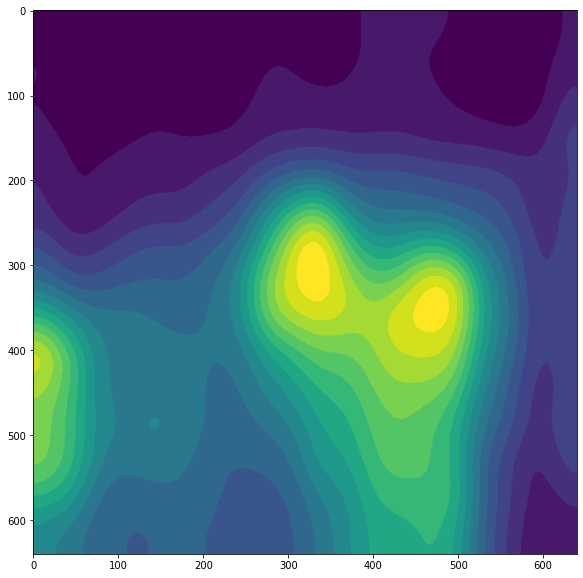

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (1, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (2, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 78, 4), (10, 2.6070974421975235, 0.0, 0.0, 1.6070974421975235, 1, 77, 4), (11, 2.6973718331752026, 0.0, 0.0, 1.6973718331752026, 1, 76, 4), (0, 10.619702102147958, 0.02758571874048561, 3570.0, 1.4117955086337866, 1, 75, 4), (3, 10.832071867964977, 0.02758571874048561, 3570.0, 1.624165274450806, 1, 74, 4), (4, 12.423040194759126, 0.09692897442771567, 16065.0, 1.6417129487814521, 1, 73, 4), (75, 13.067316593284469, 0.15695564531198564, 29325.0, 1.624165274450806, 1, 72, 4), (9, 14.80669462920112, 0.48690965987684814, 135915.0, 1.5, 1, 71, 4), (80, 15.479539094814607, 0.6902207637453268, 237405.0, 1.4117955086337866, 1, 70, 4), (16, 15.760714200952577, 0.714648270467992, 252450.0, 1.6070974421975235, 1, 69, 4), (8, 16.138162218047366, 0.8765603667159612, 380715.0, 1.4117955086337866, 1, 68, 4), (55, 16.16909354329787, 1.0818993614185612, 240343.0, 1.6973718331752

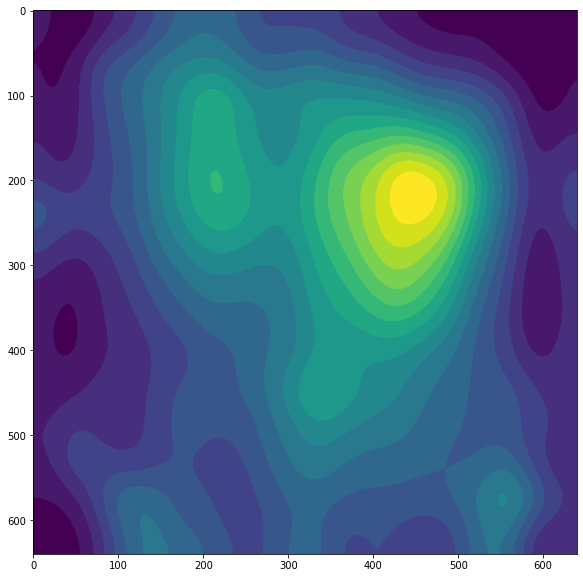

[(8, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (7, 16.051629755254528, 1.2921585329996599, 210970.0, 1.5, 1, 79, 4), (0, 16.088390480922822, 1.1587270778500902, 273175.0, 1.4117955086337866, 1, 78, 4), (44, 16.138096574516794, 1.0042940433224585, 266223.0, 1.6417129487814521, 1, 77, 4), (54, 16.138533053032198, 1.0297827784509563, 277729.0, 1.5743491774985174, 1, 76, 4), (72, 16.261653451708757, 1.4237666235781097, 249220.0, 1.4117955086337866, 1, 75, 4), (78, 16.26781679931601, 1.0479568746110601, 310367.0, 1.5743491774985174, 1, 74, 4), (62, 16.36147702493778, 1.1774551652993352, 299441.0, 1.5743491774985174, 1, 73, 4), (17, 16.440188221711534, 1.3627761828025713, 289935.0, 1.5, 1, 72, 4), (75, 16.606250077247694, 0.9413979670462311, 460785.0, 1.624165274450806, 1, 71, 4), (65, 16.612065502564427, 1.0069453148072578, 403426.0, 1.6973718331752026, 1, 70, 4), (53, 16.640121713672855, 1.0842403817897952, 413212.0, 1.624165274450806, 1, 69, 4), (77, 16.67272302487578, 

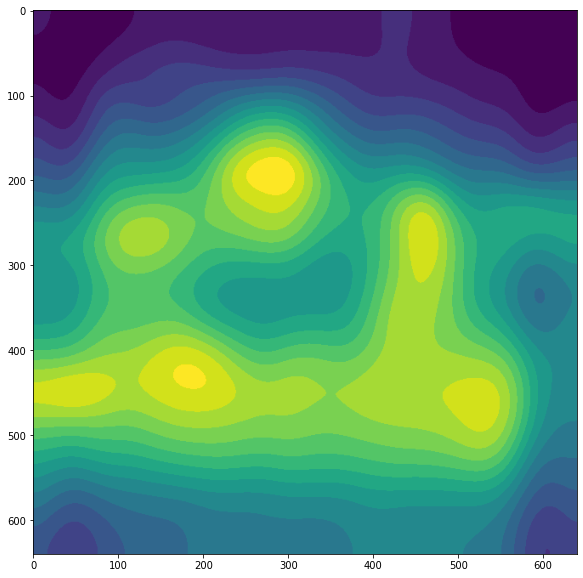

[(8, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (0, 14.683258657917843, 0.47829572095974016, 132345.0, 1.4117955086337866, 1, 79, 4), (7, 14.799214368828657, 0.4850738171240637, 135150.0, 1.5, 1, 78, 4), (3, 15.817093985885847, 0.9839453062789043, 200583.0, 1.624165274450806, 1, 77, 4), (75, 15.867915531849771, 0.9487239556585648, 218606.0, 1.624165274450806, 1, 76, 4), (40, 15.906667995872183, 1.0512527219553043, 140845.0, 2.0, 1, 75, 4), (78, 15.94030064268783, 0.7754330787750494, 293760.0, 1.5743491774985174, 1, 74, 4), (4, 16.004271025373335, 1.0397696313657485, 224760.0, 1.6417129487814521, 1, 73, 4), (36, 16.214550102578272, 1.1424456478987852, 250294.0, 1.6417129487814521, 1, 72, 4), (17, 16.27576885990756, 1.172942271871545, 297398.0, 1.5, 1, 71, 4), (76, 16.58639878889941, 1.256928060568208, 323760.0, 1.6417129487814521, 1, 70, 4), (2, 16.64410487294615, 1.314310978725779, 346433.0, 1.5743491774985174, 1, 69, 4), (5, 16.82957504707535, 0.9853572292669635, 551

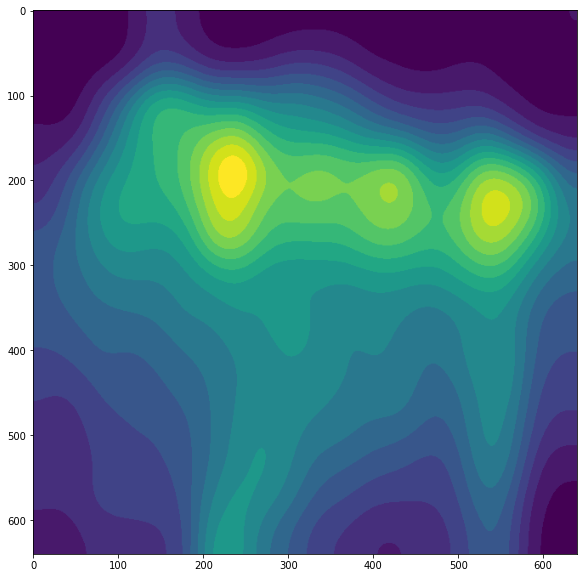

[(0, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (8, 12.4108801949408, 0.11401571929490308, 19635.0, 1.4117955086337866, 1, 79, 4), (6, 13.371958485273995, 0.2000999572687448, 40035.0, 1.5743491774985174, 1, 78, 4), (63, 13.456471538436173, 0.22225114238753588, 45900.0, 1.5, 1, 77, 4), (7, 14.142877456106557, 0.33956252816795485, 81090.0, 1.5, 1, 76, 4), (9, 15.780316591598922, 1.2018784737130215, 176035.0, 1.5, 1, 75, 4), (17, 15.95925364546258, 1.2750687996904364, 195670.0, 1.5, 1, 74, 4), (5, 16.005953000956662, 1.2235669354953322, 190655.0, 1.624165274450806, 1, 73, 4), (64, 16.150467240697274, 0.14668470202047534, 657819.0, 1.6070974421975235, 1, 72, 4), (3, 16.50294655613171, 1.4334358629066524, 254065.0, 1.624165274450806, 1, 71, 4), (73, 16.549379198613387, 0.9564034381036496, 485520.0, 1.5, 1, 70, 4), (54, 16.559277597525373, 1.1208436647050652, 386190.0, 1.5743491774985174, 1, 69, 4), (80, 16.596081574852306, 1.7147459188572074, 260287.0, 1.4117955086337866, 

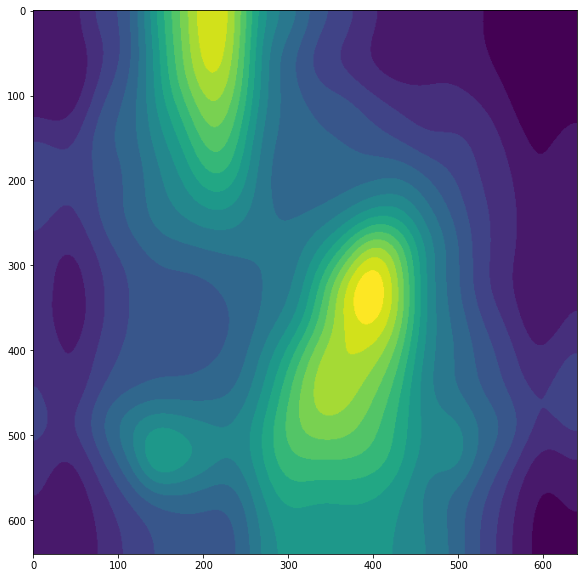

[(8, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (44, 11.636728907893907, 0.0525550322918736, 7650.0, 1.6417129487814521, 1, 78, 4), (35, 11.867005218407401, 0.06399023907178274, 9690.0, 1.624165274450806, 1, 77, 4), (72, 12.815222993756311, 0.15263373865176422, 28305.0, 1.4117955086337866, 1, 76, 4), (47, 13.425683292921168, 0.1696820980080266, 32385.0, 1.8705505632961241, 1, 75, 4), (17, 13.469404692234656, 0.22413445999943485, 46410.0, 1.5, 1, 74, 4), (0, 15.240962965754237, 0.6234948916116151, 199920.0, 1.4117955086337866, 1, 73, 4), (80, 15.869400928797655, 1.0143640376586145, 253531.0, 1.4117955086337866, 1, 72, 4), (54, 15.964655228632239, 1.0117938486640448, 237640.0, 1.5743491774985174, 1, 71, 4), (9, 16.278184555023294, 1.2076806238947335, 287939.0, 1.5, 1, 70, 4), (22, 16.4202592705153, 0.14357433546047713, 648009.0, 1.8950250709279723, 1, 69, 4), (62, 16.4954148490929, 0.9065392069229136, 4488

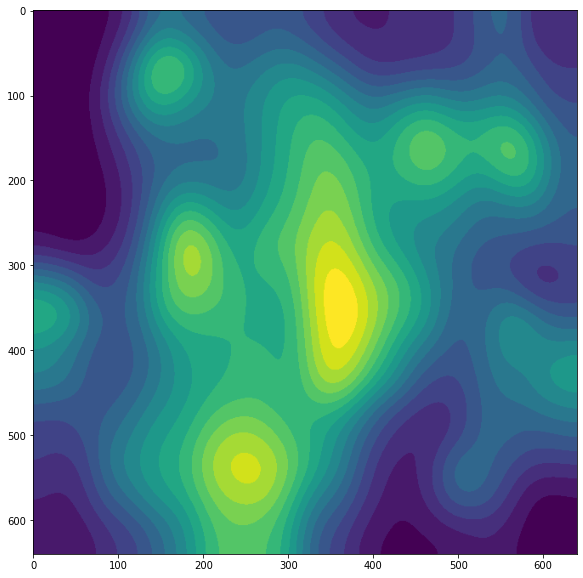

[(0, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (18, 9.511223978634188, 0.00931689485735376, 1020.0, 1.5743491774985174, 1, 79, 4), (9, 13.866635719760884, 0.2880379075839226, 64770.0, 1.5, 1, 78, 4), (72, 15.021274218794623, 0.7910926513871852, 135725.0, 1.4117955086337866, 1, 77, 4), (80, 15.079778070034017, 0.8051892684242467, 141888.0, 1.4117955086337866, 1, 76, 4), (27, 15.68434323407818, 0.9499446338713898, 181722.0, 1.624165274450806, 1, 75, 4), (6, 15.729222366184532, 0.9604885829510311, 197676.0, 1.5743491774985174, 1, 74, 4), (8, 16.175184839577557, 1.3758913634514585, 239785.0, 1.4117955086337866, 1, 73, 4), (46, 16.56399844084462, 1.54605292375301, 211100.0, 1.757858283255199, 1, 72, 4), (63, 16.757661257287705, 1.342403233424851, 406467.0, 1.5, 1, 71, 4), (3, 16.765213948990795, 1.5097082936054724, 306000.0, 1.624165274450806, 1, 70, 4), (12, 16.871620978765897, 1.3477628819574843, 350109.0, 1.757858283255199, 1, 69, 4), (44, 17.009660073393782, 1.4484590

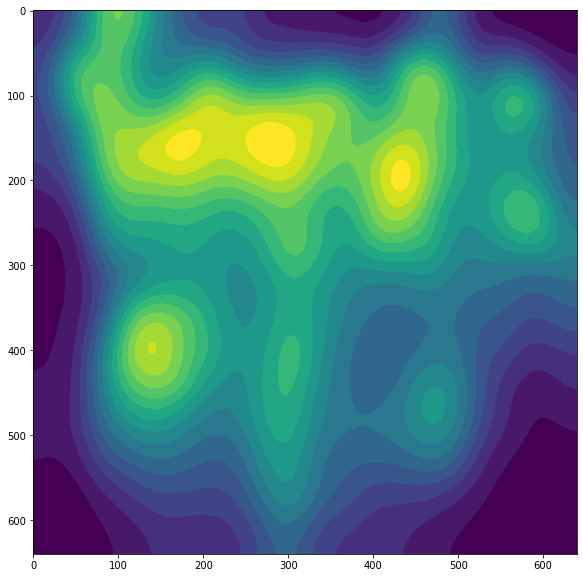

[(80, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (72, 12.893419343220645, 0.1612367963169008, 30345.0, 1.4117955086337866, 1, 79, 4), (71, 13.469404692234656, 0.22413445999943485, 46410.0, 1.5, 1, 78, 4), (79, 15.319623585913835, 0.8574330568472721, 156716.0, 1.5, 1, 77, 4), (25, 15.879643635445575, 0.952721916562099, 204751.0, 1.6973718331752026, 1, 76, 4), (74, 15.96477284939094, 0.9799337218496088, 245362.0, 1.5743491774985174, 1, 75, 4), (54, 16.47531863568775, 1.5838743560829323, 223484.0, 1.5743491774985174, 1, 74, 4), (63, 16.624291550502626, 1.6075004688023282, 272881.0, 1.5, 1, 73, 4), (8, 16.650420053551553, 1.9728265052846516, 212309.0, 1.4117955086337866, 1, 72, 4), (36, 16.66741608221314, 1.6439769463239253, 238405.0, 1.6417129487814521, 1, 71, 4), (50, 16.70025276314252, 1.1979727701164917, 283856.0, 1.946057646725596, 1, 70, 4), (77, 16.767173742162026, 1.3301257005597145, 366914.0, 1.624165274450806, 1, 69, 4), (62, 16.924931770720296, 0.97841036479384

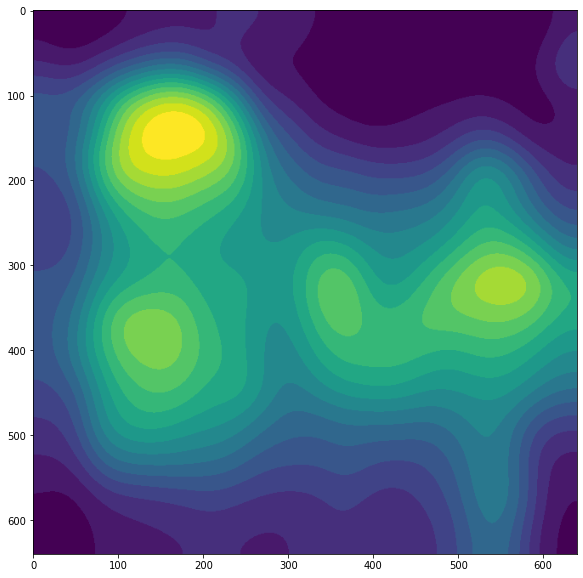

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (5, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 78, 4), (72, 14.31573462982222, 0.5627395458787933, 84221.0, 1.4117955086337866, 1, 77, 4), (77, 15.182265357651689, 0.5506918138048373, 163965.0, 1.624165274450806, 1, 76, 4), (14, 15.498232784302749, 0.5992404566762857, 187425.0, 1.757858283255199, 1, 75, 4), (15, 15.930022984275418, 0.96931954122991, 211786.0, 1.6973718331752026, 1, 74, 4), (0, 16.157289570376303, 1.3704806509124476, 236810.0, 1.4117955086337866, 1, 73, 4), (3, 16.247585184099325, 1.3663072518039914, 210473.0, 1.624165274450806, 1, 72, 4), (78, 16.516559341567348, 1.2484597511135784, 325706.0, 1.5743491774985174, 1, 71, 4), (27, 16.575289483751675, 1.6204738862858028, 226534.0, 1.624165274450806, 1, 70, 4), (76, 16.64676555998822, 0.6322745434977135, 642279.0, 1.6417129487814521, 1, 69, 4), (16, 16.748945444913343, 1.5105076217813, 306000.0, 1.6070974421975235, 

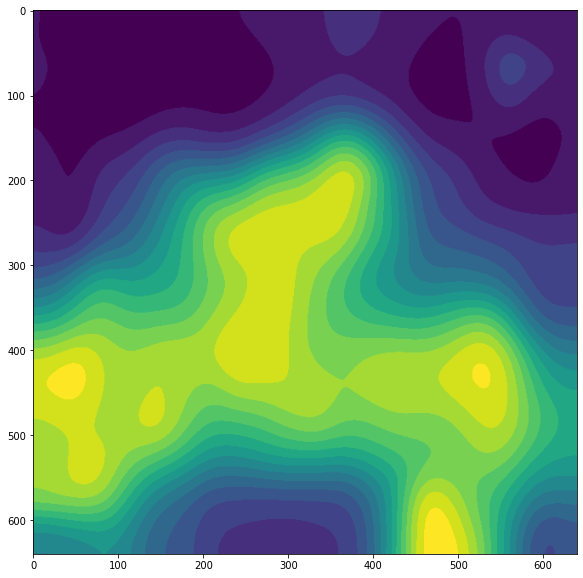

[(1, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (2, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (9, 14.259387641641606, 0.3630521742807526, 88995.0, 1.5, 1, 78, 4), (10, 14.36648508383913, 0.3630521742807526, 88995.0, 1.6070974421975235, 1, 77, 4), (4, 14.538674071248696, 0.39211823369037174, 99195.0, 1.6417129487814521, 1, 76, 4), (0, 15.174403512921277, 0.6052792739962451, 190485.0, 1.4117955086337866, 1, 75, 4), (8, 15.442160907399803, 0.9408209515300456, 178001.0, 1.4117955086337866, 1, 74, 4), (44, 15.858314348952124, 1.307271753582792, 148647.0, 1.6417129487814521, 1, 73, 4), (55, 16.02509506604599, 0.7644832646401993, 285855.0, 1.6973718331752026, 1, 72, 4), (27, 16.08684997459335, 1.3883450652955127, 175315.0, 1.624165274450806, 1, 71, 4), (11, 16.15930823048237, 1.0671832890811712, 241531.0, 1.6973718331752026, 1, 70, 4), (3, 16.29991570543382, 0.8627831789372169, 366945.0, 1.624165274450806, 1, 69, 4), (15, 16.368871368638256, 1.4488107065100728, 203351.0, 1.697371833175

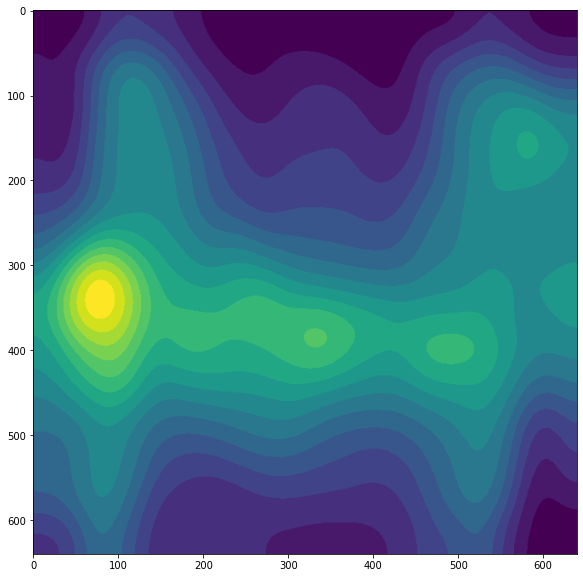

[(35, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 80, 4), (5, 13.606375829166144, 0.22601125194792618, 46920.0, 1.624165274450806, 1, 79, 4), (74, 14.136628962919993, 0.3239227537576442, 75990.0, 1.5743491774985174, 1, 78, 4), (3, 14.890527083049111, 0.4770553889314494, 131835.0, 1.624165274450806, 1, 77, 4), (80, 15.835911147204511, 1.238194681251404, 196010.0, 1.4117955086337866, 1, 76, 4), (9, 16.21763719611525, 1.37249850246208, 229840.0, 1.5, 1, 75, 4), (4, 16.268618968305745, 0.8493031316115198, 354195.0, 1.6417129487814521, 1, 74, 4), (0, 16.293182247264127, 1.431368414156696, 255255.0, 1.4117955086337866, 1, 73, 4), (75, 16.316167245011115, 0.32913618242917203, 635944.0, 1.624165274450806, 1, 72, 4), (6, 16.687501652771275, 1.6797888907427647, 251039.0, 1.5743491774985174, 1, 71, 4), (44, 16.737243474315278, 0.9659433030401773, 503625.0, 1.6417129487814521, 1, 70, 4), (76, 16.757481274850253, 1.2349543532180811, 392705.0, 1.6417129487814521, 1, 69, 4), (53, 16.952738585

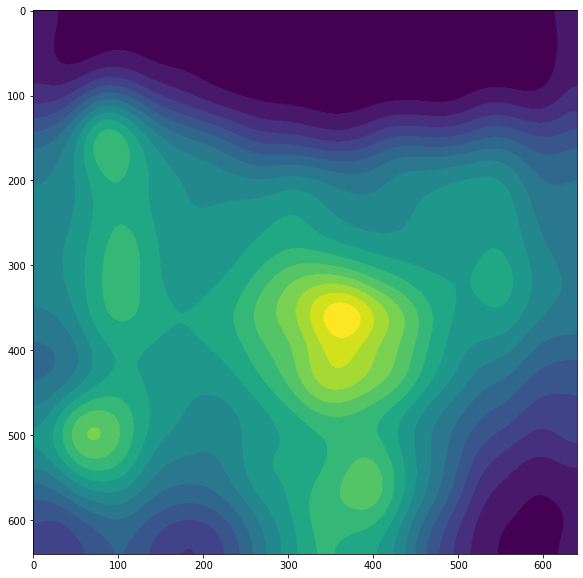

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (5, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 78, 4), (3, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 77, 4), (4, 2.641712948781452, 0.0, 0.0, 1.6417129487814521, 1, 76, 4), (2, 13.562915769927908, 0.22694722219263944, 47175.0, 1.5743491774985174, 1, 75, 4), (1, 15.678077690517446, 0.980672499078833, 198274.0, 1.5, 1, 74, 4), (8, 16.297043820017727, 0.9180311091479738, 428145.0, 1.4117955086337866, 1, 73, 4), (35, 16.301591173001512, 1.1700937721550626, 270312.0, 1.624165274450806, 1, 72, 4), (27, 16.305437020431366, 1.1568253725320217, 274978.0, 1.624165274450806, 1, 71, 4), (34, 16.32629238110481, 0.20007977009573813, 639444.0, 1.757858283255199, 1, 70, 4), (80, 16.377173602217017, 0.9375012352848491, 454920.0, 1.4117955086337866, 1, 69, 4), (14, 16.433587057882153, 1.3640581416376152, 222275.0, 1.757858283255199, 1, 68, 4), (38, 16.490646316897983, 0.840589392692942

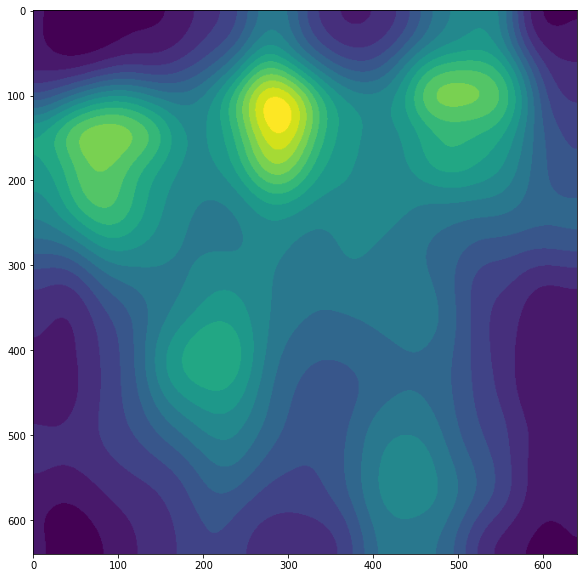

[(53, 12.865814810096145, 0.1360377990190764, 24480.0, 1.624165274450806, 1, 80, 4), (62, 14.581845191456544, 0.4164990135676422, 108120.0, 1.5743491774985174, 1, 79, 4), (71, 15.68852521902417, 0.7246177823898561, 258825.0, 1.5, 1, 78, 4), (58, 15.93648715207992, 0.8924202105490905, 188913.0, 1.8950250709279723, 1, 77, 4), (23, 16.03493548756044, 0.9397800659159473, 203741.0, 1.8705505632961241, 1, 76, 4), (0, 16.133706626644543, 1.1428965560779774, 290400.0, 1.4117955086337866, 1, 75, 4), (76, 16.23135367217033, 1.0488688406438655, 279504.0, 1.6417129487814521, 1, 74, 4), (45, 16.275267988536037, 1.0408391051579582, 299618.0, 1.624165274450806, 1, 73, 4), (72, 16.579136494136137, 0.9792460489134424, 533970.0, 1.4117955086337866, 1, 72, 4), (80, 16.595537798028516, 1.1434917609285353, 460584.0, 1.4117955086337866, 1, 71, 4), (41, 16.60850103791, 0.22402272207589918, 667853.0, 1.9726549474122854, 1, 70, 4), (40, 16.648794378422572, 0.2500394270432271, 659182.0, 2.0, 1, 69, 4), (54, 16.

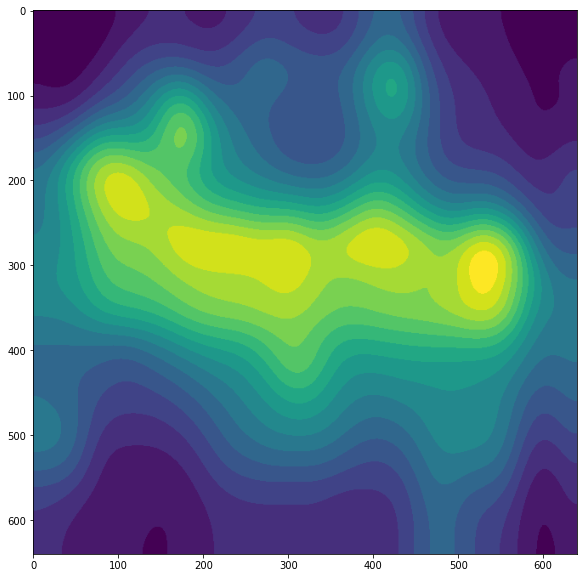

[(0, 12.466263526546843, 0.11875531808219239, 20655.0, 1.4117955086337866, 1, 80, 4), (77, 13.273736940368916, 0.18105443560248002, 35190.0, 1.624165274450806, 1, 79, 4), (8, 13.714867376775935, 0.2770113894930678, 61455.0, 1.4117955086337866, 1, 78, 4), (13, 14.755922393959626, 0.40962829531538597, 105570.0, 1.7791645796604998, 1, 77, 4), (75, 14.972558568332184, 0.4972114704964354, 140250.0, 1.624165274450806, 1, 76, 4), (76, 15.572914076950868, 0.6517850884150325, 215220.0, 1.6417129487814521, 1, 75, 4), (64, 16.109557741130217, 1.075350318605891, 249474.0, 1.6070974421975235, 1, 74, 4), (16, 16.452112113770205, 1.0337848830224252, 366308.0, 1.6070974421975235, 1, 73, 4), (7, 16.55138774026856, 0.7578665561522084, 593339.0, 1.5, 1, 72, 4), (80, 16.749958217665352, 0.9659733438578515, 641901.0, 1.4117955086337866, 1, 71, 4), (26, 16.758810207495397, 1.4345971468782541, 344505.0, 1.5743491774985174, 1, 70, 4), (74, 16.78581450978497, 0.8393117988252109, 641878.0, 1.5743491774985174, 1

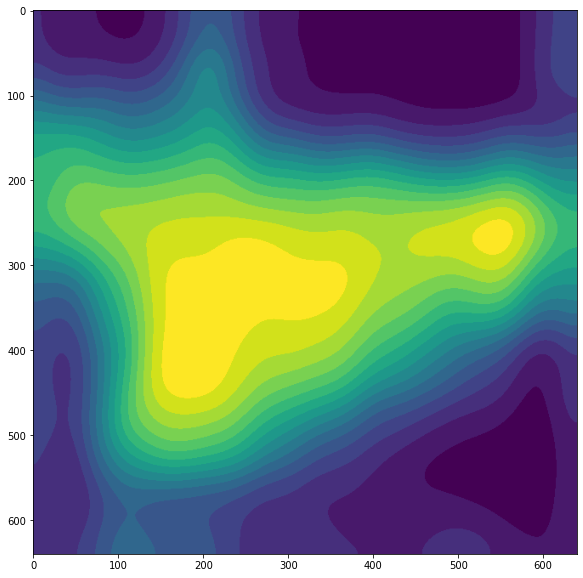

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (5, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 78, 4), (39, 2.9726549474122854, 0.0, 0.0, 1.9726549474122854, 1, 77, 4), (70, 13.987990720404245, 0.2905536481530736, 65535.0, 1.6070974421975235, 1, 76, 4), (77, 14.991788469938625, 0.5020006879480821, 142290.0, 1.624165274450806, 1, 75, 4), (72, 15.087337911623186, 0.5817709707963827, 178755.0, 1.4117955086337866, 1, 74, 4), (63, 15.768747016902054, 1.198551369923233, 174590.0, 1.5, 1, 73, 4), (0, 15.992258349286182, 1.0940802300000625, 264708.0, 1.4117955086337866, 1, 72, 4), (76, 16.30988891033024, 0.3068996260836575, 634934.0, 1.6417129487814521, 1, 71, 4), (15, 16.351086162997447, 1.33101487236035, 224740.0, 1.6973718331752026, 1, 70, 4), (71, 16.419613968623285, 0.9265281869369301, 439365.0, 1.5, 1, 69, 4), (75, 16.532792656861684, 1.3436048825140081, 286365.0, 1.624165274450806, 1, 68, 4), (74, 16.625160787100757, 0.609754

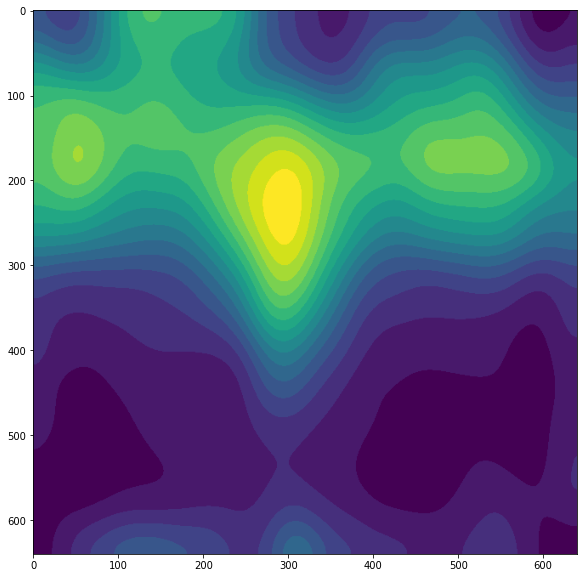

[(69, 2.6973718331752026, 0.0, 0.0, 1.6973718331752026, 1, 80, 4), (56, 2.8010698775896223, 0.0, 0.0, 1.8010698775896221, 1, 79, 4), (61, 13.692263638555813, 0.22788158650898407, 47430.0, 1.6973718331752026, 1, 78, 4), (60, 13.731282067206735, 0.2184646494205345, 44880.0, 1.8010698775896221, 1, 77, 4), (63, 13.985551528938643, 0.3094983806109678, 71400.0, 1.5, 1, 76, 4), (64, 14.808179960377036, 0.46134025652877664, 125460.0, 1.6070974421975235, 1, 75, 4), (66, 14.950912035879968, 0.45942771799147036, 124695.0, 1.757858283255199, 1, 74, 4), (72, 16.197648483120087, 1.3919945615230116, 241315.0, 1.4117955086337866, 1, 73, 4), (80, 16.342314610767787, 0.9382120196495496, 439023.0, 1.4117955086337866, 1, 72, 4), (71, 16.55795404682588, 1.1652579540855106, 397399.0, 1.5, 1, 71, 4), (2, 16.56111037683904, 1.0913034409612872, 398498.0, 1.5743491774985174, 1, 70, 4), (62, 16.63237019396143, 0.9582407282588409, 488835.0, 1.5743491774985174, 1, 69, 4), (54, 16.688624408875214, 0.969612346477598

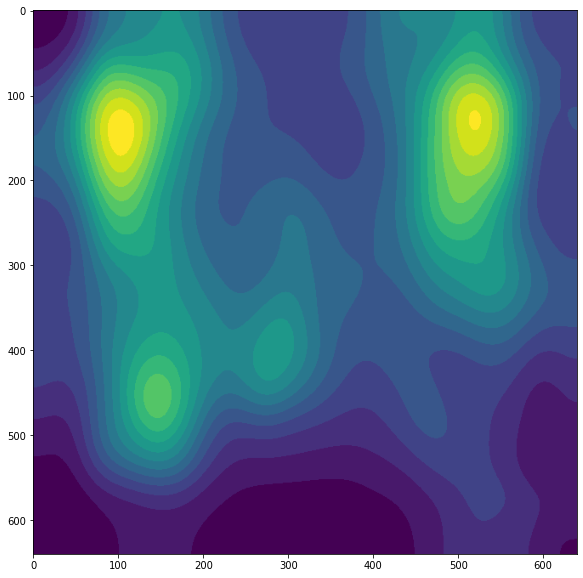

[(76, 2.641712948781452, 0.0, 0.0, 1.6417129487814521, 1, 80, 4), (4, 2.641712948781452, 0.0, 0.0, 1.6417129487814521, 1, 79, 4), (13, 11.353523601984524, 0.037363203611607, 5100.0, 1.7791645796604998, 1, 78, 4), (72, 11.923812460398022, 0.07893310849518254, 12495.0, 1.4117955086337866, 1, 77, 4), (77, 13.105789109037664, 0.1612367963169008, 30345.0, 1.624165274450806, 1, 76, 4), (75, 14.023840787739683, 0.2938915608077553, 66555.0, 1.624165274450806, 1, 75, 4), (71, 14.646721391869157, 0.44847886112517643, 120360.0, 1.5, 1, 74, 4), (21, 15.864521119696777, 0.6693818106382676, 225165.0, 1.8705505632961241, 1, 73, 4), (79, 15.940501262338511, 0.7967383614054373, 309825.0, 1.5, 1, 72, 4), (62, 15.964839698140418, 0.9789536868155095, 245619.0, 1.5743491774985174, 1, 71, 4), (45, 16.092785689379156, 1.101326431408245, 234989.0, 1.624165274450806, 1, 70, 4), (8, 16.244918899497524, 1.564071251347513, 213001.0, 1.4117955086337866, 1, 69, 4), (36, 16.4027950720659, 1.3911065064843364, 235620.

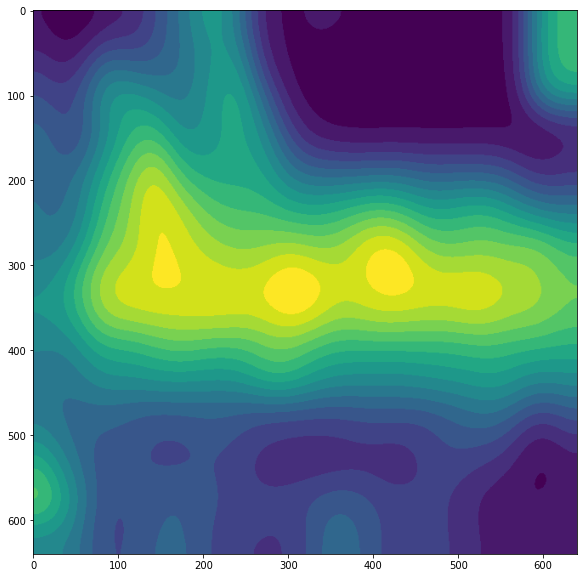

[(80, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (5, 12.70537281819465, 0.12110339078881974, 21165.0, 1.624165274450806, 1, 78, 4), (15, 14.010418054038015, 0.27872123236383695, 61965.0, 1.6973718331752026, 1, 77, 4), (14, 14.26945809194052, 0.31434445270704175, 72930.0, 1.757858283255199, 1, 76, 4), (16, 15.002873309824654, 0.7142390695961982, 118366.0, 1.6070974421975235, 1, 75, 4), (7, 15.497888216266862, 0.929245983241225, 174319.0, 1.5, 1, 74, 4), (4, 15.849998258946961, 0.9442079423487607, 211944.0, 1.6417129487814521, 1, 73, 4), (67, 15.858857510373987, 0.8979590853726743, 195191.0, 1.7791645796604998, 1, 72, 4), (64, 16.344247431334963, 0.3250047453923741, 668068.0, 1.6070974421975235, 1, 71, 4), (73, 16.350654032206993, 0.5153962469816727, 618627.0, 1.5, 1, 70, 4), (75, 16.48043094793912, 0.5368267828242295, 608918.0, 1.624165274450806, 1, 69, 4), (68, 16.487006555904795, 1.0750907664980507, 313

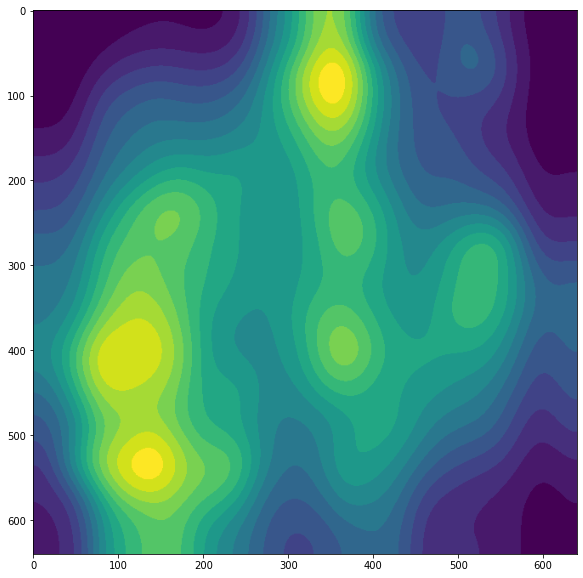

[(0, 11.626566700455914, 0.06258973401947458, 9435.0, 1.4117955086337866, 1, 80, 4), (8, 14.908150871805917, 0.7407818032297118, 127462.0, 1.4117955086337866, 1, 79, 4), (17, 15.030977969483718, 0.7476208689682399, 131053.0, 1.5, 1, 78, 4), (80, 15.133388711146742, 0.5941580024998527, 184875.0, 1.4117955086337866, 1, 77, 4), (9, 16.143759619536034, 1.3549095475482906, 217260.0, 1.5, 1, 76, 4), (6, 16.214300838390333, 1.1213226395091922, 273383.0, 1.5743491774985174, 1, 75, 4), (26, 16.32354174330276, 1.3159644275699995, 251005.0, 1.5743491774985174, 1, 74, 4), (79, 16.643360529745898, 0.9750395675685388, 523515.0, 1.5, 1, 73, 4), (30, 16.653674018765397, 1.1201322685051807, 292870.0, 1.946057646725596, 1, 72, 4), (48, 16.705107326274423, 1.0688270627676504, 324559.0, 1.946057646725596, 1, 71, 4), (1, 16.707812556320526, 1.5544932686672313, 312800.0, 1.5, 1, 70, 4), (53, 16.78217821998479, 1.5011672741911026, 313905.0, 1.624165274450806, 1, 69, 4), (51, 16.79963311460462, 0.973917268936

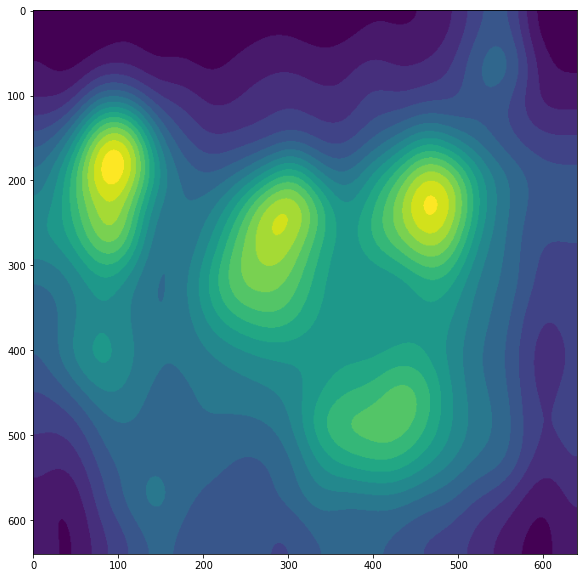

[(0, 13.87066441671016, 0.44987621061496347, 60415.0, 1.4117955086337866, 1, 80, 4), (41, 14.977206422301462, 0.6051419127500579, 89269.0, 1.9726549474122854, 1, 79, 4), (2, 15.45710077526254, 0.6382999393647327, 207825.0, 1.5743491774985174, 1, 78, 4), (50, 15.614549365345054, 0.7956216608428743, 143325.0, 1.946057646725596, 1, 77, 4), (44, 15.93658970986507, 1.0241874724674718, 213350.0, 1.6417129487814521, 1, 76, 4), (56, 16.197095395688653, 0.7840378656803271, 300135.0, 1.8010698775896221, 1, 75, 4), (72, 16.320744207822376, 0.9287135616342993, 433755.0, 1.4117955086337866, 1, 74, 4), (1, 16.357694260164628, 1.2400286535601746, 301844.0, 1.5, 1, 73, 4), (3, 16.481235417243383, 0.9109190220180268, 419220.0, 1.624165274450806, 1, 72, 4), (74, 16.50753063593335, 1.1866175964829158, 343370.0, 1.5743491774985174, 1, 71, 4), (65, 16.529133343596268, 0.4405197469687652, 654248.0, 1.6973718331752026, 1, 70, 4), (80, 16.662496879991995, 1.058979855851566, 535910.0, 1.4117955086337866, 1, 69

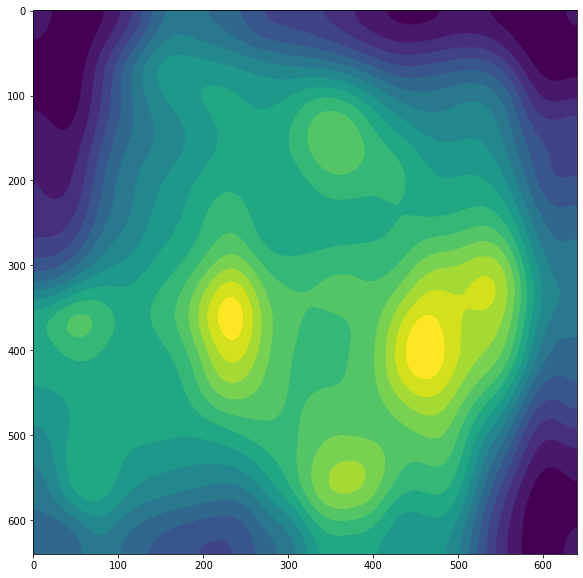

[(55, 2.6973718331752026, 0.0, 0.0, 1.6973718331752026, 1, 80, 4), (31, 13.992545713998062, 0.23160314926686437, 48450.0, 1.9726549474122854, 1, 79, 4), (8, 14.458418830194713, 0.6174817203364087, 91963.0, 1.4117955086337866, 1, 78, 4), (80, 14.938098883168468, 0.7389558639722127, 131577.0, 1.4117955086337866, 1, 77, 4), (0, 15.314785908918152, 0.643922160102248, 210885.0, 1.4117955086337866, 1, 76, 4), (18, 15.758794402534212, 1.1570208909331814, 167280.0, 1.5743491774985174, 1, 75, 4), (46, 16.024239445303266, 0.7469038742589439, 273615.0, 1.757858283255199, 1, 74, 4), (9, 16.089613108153756, 1.1346122123356441, 256530.0, 1.5, 1, 73, 4), (56, 16.371315779692445, 1.3290715919873, 207145.0, 1.8010698775896221, 1, 72, 4), (32, 16.724450142035497, 0.8904737869749348, 395505.0, 1.946057646725596, 1, 71, 4), (59, 16.92913846549143, 0.9332290158111798, 501500.0, 1.8705505632961241, 1, 70, 4), (72, 16.986061676136877, 1.905460006074361, 317682.0, 1.4117955086337866, 1, 69, 4), (49, 16.995581

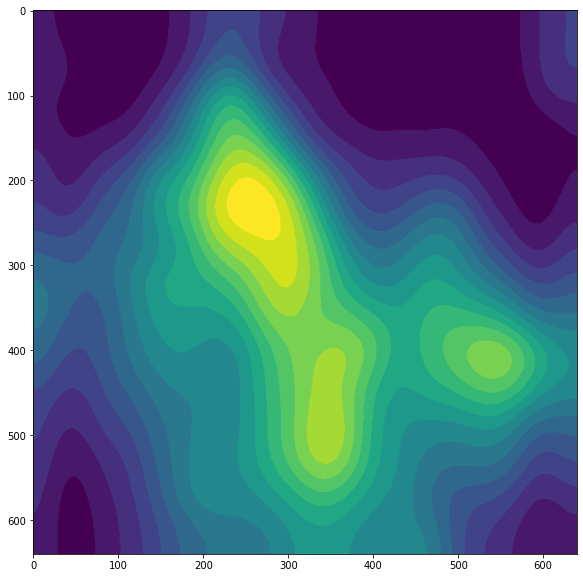

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (1, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 78, 4), (5, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 77, 4), (16, 8.846563475612705, 0.0050553076968103275, 510.0, 1.6070974421975235, 1, 76, 4), (15, 13.120823070791023, 0.15479987374505338, 28815.0, 1.6973718331752026, 1, 75, 4), (26, 14.140770528799322, 0.324714232751694, 76245.0, 1.5743491774985174, 1, 74, 4), (80, 15.286559332300687, 0.854334245043076, 166114.0, 1.4117955086337866, 1, 73, 4), (14, 15.592295660557891, 0.6249455837268623, 200685.0, 1.757858283255199, 1, 72, 4), (10, 16.02082406819457, 1.2510574290744867, 191505.0, 1.6070974421975235, 1, 71, 4), (72, 16.232364134995606, 1.1652309167353105, 313432.0, 1.4117955086337866, 1, 70, 4), (75, 16.679687459424905, 1.247757229950751, 365041.0, 1.624165274450806, 1, 69, 4), (0, 16.69924024660777, 0.9955664600451449, 592365.0, 1.4117955086337866, 1, 68, 4), (77, 16.72881839412135, 1.5292953734

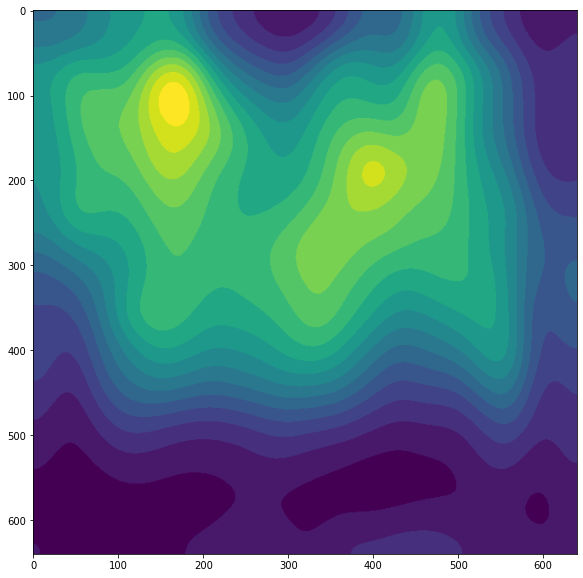

[(73, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (72, 12.352734197699702, 0.10921570275909767, 18615.0, 1.4117955086337866, 1, 79, 4), (79, 12.607352240519141, 0.12343743887039862, 21675.0, 1.5, 1, 78, 4), (74, 15.401755882279854, 0.6230104636321071, 199665.0, 1.5743491774985174, 1, 77, 4), (71, 15.605346792715133, 0.9191299758963096, 196068.0, 1.5, 1, 76, 4), (8, 16.160569039398894, 1.3044322961756567, 253810.0, 1.4117955086337866, 1, 75, 4), (17, 16.21265628585155, 1.1913423362531224, 274118.0, 1.5, 1, 74, 4), (62, 16.492541343921463, 1.600215957732967, 223681.0, 1.5743491774985174, 1, 73, 4), (63, 16.503437131999647, 0.9462845016260958, 468435.0, 1.5, 1, 72, 4), (38, 16.667320264628376, 0.45446207693441726, 607941.0, 1.8950250709279723, 1, 71, 4), (68, 16.699600761515615, 1.243241404342709, 327257.0, 1.757858283255199, 1, 70, 4), (44, 16.735798042255794, 1.523438781212078, 287980.0, 1.6417129487814521, 1, 69, 4), (54, 16.74189053458289, 1.2630081719207535, 402131.0, 1.5743491774985174, 1, 68, 4

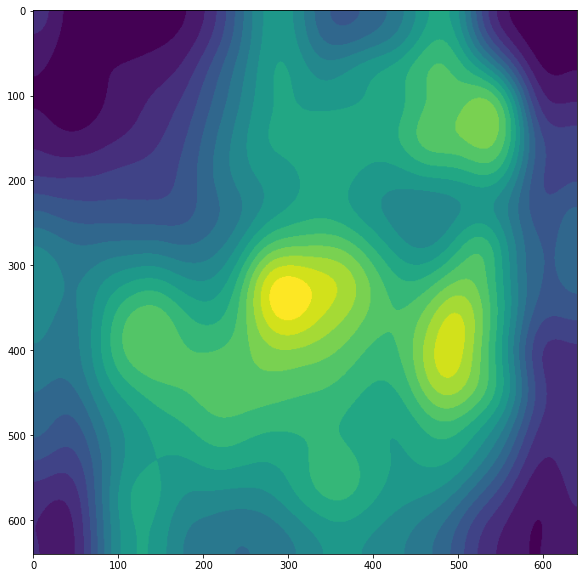

[(8, 14.562959223454572, 0.874391055758405, 78966.0, 1.4117955086337866, 1, 80, 4), (1, 15.019718670493996, 0.5407034755991675, 159375.0, 1.5, 1, 79, 4), (9, 15.083157405407361, 0.557258624613682, 167025.0, 1.5, 1, 78, 4), (33, 15.640799879430855, 0.8447507315969607, 151070.0, 1.8705505632961241, 1, 77, 4), (45, 16.157562980017023, 1.0854893016356082, 254717.0, 1.624165274450806, 1, 76, 4), (0, 16.284530437711314, 1.2509729547045414, 303083.0, 1.4117955086337866, 1, 75, 4), (80, 16.36295632623985, 0.6389724381283626, 604519.0, 1.4117955086337866, 1, 74, 4), (59, 16.467410034156426, 1.0808199147005035, 272676.0, 1.8705505632961241, 1, 73, 4), (36, 16.49875357609465, 0.9707110243276823, 394877.0, 1.6417129487814521, 1, 72, 4), (71, 16.60019194988438, 1.5119057643066747, 293105.0, 1.5, 1, 71, 4), (72, 16.7937997628141, 1.662195225258188, 334305.0, 1.4117955086337866, 1, 70, 4), (75, 16.910264387210525, 1.055311916405681, 557260.0, 1.624165274450806, 1, 69, 4), (44, 17.01795690132302, 1.60

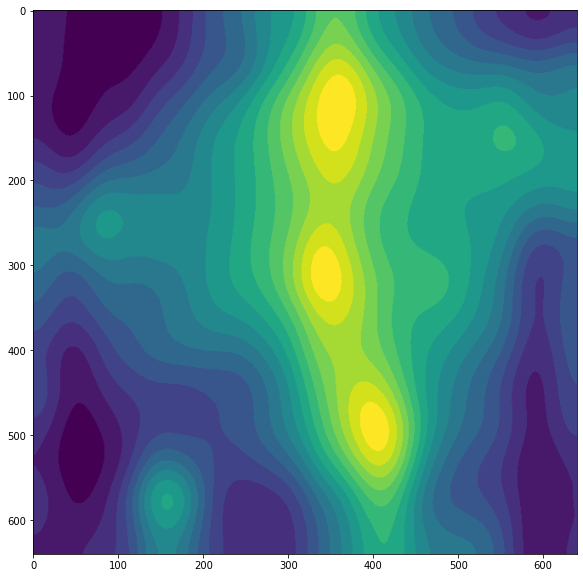

[(1, 14.259387641641606, 0.3630521742807526, 88995.0, 1.5, 1, 80, 4), (80, 15.42766660197887, 0.6755516861278612, 228735.0, 1.4117955086337866, 1, 79, 4), (75, 15.456848063248803, 0.6244624512103634, 200430.0, 1.624165274450806, 1, 78, 4), (71, 15.513975822373567, 0.8847788216258939, 185201.0, 1.5, 1, 77, 4), (56, 16.31764279219002, 0.8183530048263385, 327165.0, 1.8010698775896221, 1, 76, 4), (33, 16.479386851576017, 0.84427706355915, 349605.0, 1.8705505632961241, 1, 75, 4), (9, 16.640382115586103, 0.974499584268278, 522240.0, 1.5, 1, 74, 4), (63, 16.728340230963518, 1.3832994379499355, 378905.0, 1.5, 1, 73, 4), (0, 16.822504967816354, 0.9988980695164311, 667845.0, 1.4117955086337866, 1, 72, 4), (72, 16.840341281975874, 0.9293417533663209, 728836.0, 1.4117955086337866, 1, 71, 4), (29, 16.8444351668917, 0.5348042751297097, 686307.0, 1.8705505632961241, 1, 70, 4), (24, 16.84679232404275, 1.3123889779939368, 338857.0, 1.8010698775896221, 1, 69, 4), (25, 16.90452929610336, 0.77257648598968

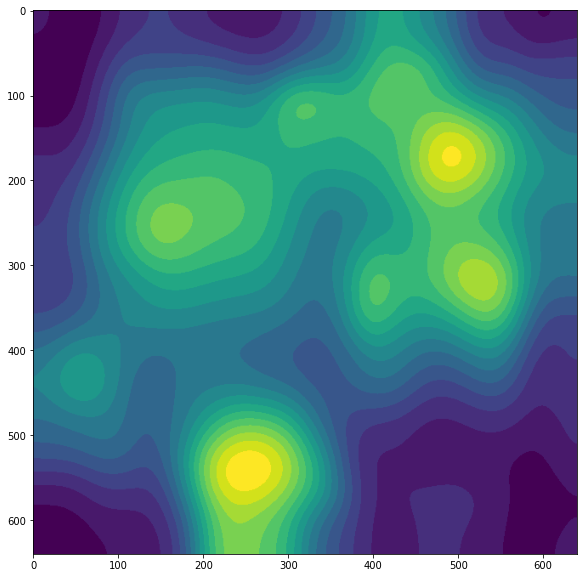

[(0, 14.900973895534175, 0.5328178825703661, 155805.0, 1.4117955086337866, 1, 80, 4), (69, 15.144090510865876, 0.5219484976482426, 150960.0, 1.6973718331752026, 1, 79, 4), (80, 15.183571660475385, 0.6077762827333307, 191760.0, 1.4117955086337866, 1, 78, 4), (72, 15.614956608439416, 0.9718740266347285, 205107.0, 1.4117955086337866, 1, 77, 4), (9, 15.941212270898305, 1.2583314896448072, 195415.0, 1.5, 1, 76, 4), (70, 16.356088652865825, 0.4037883281671314, 624810.0, 1.6070974421975235, 1, 75, 4), (36, 16.431987247017627, 1.3911462437090754, 242590.0, 1.6417129487814521, 1, 74, 4), (71, 16.465746002712486, 1.0999537027348862, 386850.0, 1.5, 1, 73, 4), (62, 16.50608500089026, 1.161116708595936, 351730.0, 1.5743491774985174, 1, 72, 4), (73, 16.831150938606157, 1.1446491200855955, 533120.0, 1.5, 1, 71, 4), (35, 16.882762337657578, 1.5629786117156583, 326315.0, 1.624165274450806, 1, 70, 4), (21, 16.95862885104421, 1.2424438545817216, 379130.0, 1.8705505632961241, 1, 69, 4), (78, 17.1566534816

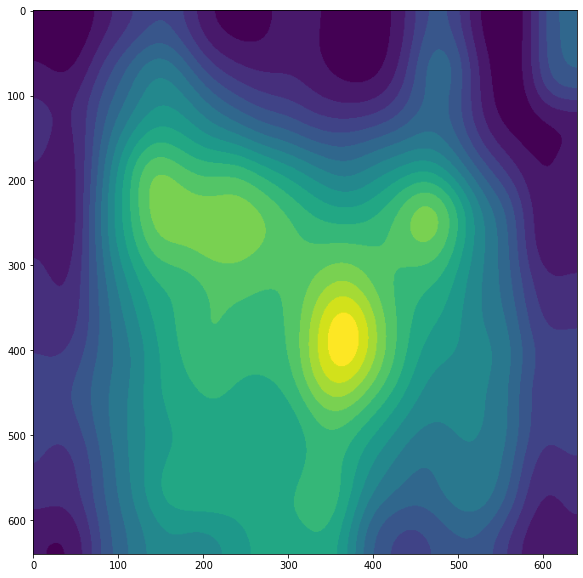

[(66, 2.757858283255199, 0.0, 0.0, 1.757858283255199, 1, 80, 4), (48, 13.41817607100417, 0.16017025465448279, 30090.0, 1.946057646725596, 1, 79, 4), (0, 14.798012705074546, 0.7156813291055132, 117071.0, 1.4117955086337866, 1, 78, 4), (5, 15.08666614470386, 0.5259757269791774, 152745.0, 1.624165274450806, 1, 77, 4), (80, 15.624668360804888, 1.1524620190722792, 172890.0, 1.4117955086337866, 1, 76, 4), (54, 15.844064454560415, 1.0024064320611512, 212630.0, 1.5743491774985174, 1, 75, 4), (62, 15.890614695833394, 1.0481433842402623, 212803.0, 1.5743491774985174, 1, 74, 4), (57, 15.921710966419365, 0.6855231879217302, 234600.0, 1.8705505632961241, 1, 73, 4), (35, 15.959652987637416, 1.2112760941367542, 184280.0, 1.624165274450806, 1, 72, 4), (27, 16.356621938998302, 1.3632028088757941, 235450.0, 1.624165274450806, 1, 71, 4), (26, 16.41752549744353, 1.155140595333949, 323850.0, 1.5743491774985174, 1, 70, 4), (71, 16.449328084861587, 1.442984194101754, 270045.0, 1.5, 1, 69, 4), (18, 16.5009243

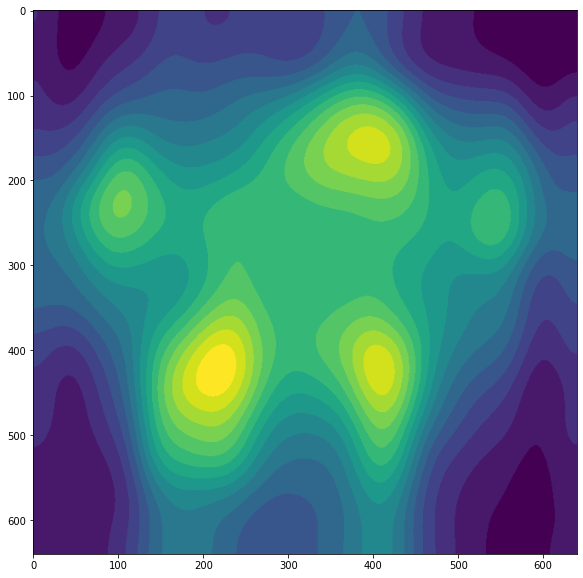

[(72, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (40, 3.0, 0.0, 0.0, 2.0, 1, 79, 4), (8, 10.933272532232865, 0.03577449927421211, 4845.0, 1.4117955086337866, 1, 78, 4), (63, 13.660662807316415, 0.2534232471361363, 54570.0, 1.5, 1, 77, 4), (31, 15.461833334312674, 0.5328178825703661, 155805.0, 1.9726549474122854, 1, 76, 4), (62, 15.613799388907633, 0.8869946107160595, 189559.0, 1.5743491774985174, 1, 75, 4), (29, 16.164099550461486, 0.7546894590250086, 278970.0, 1.8705505632961241, 1, 74, 4), (0, 16.184919546664766, 1.0766325785124762, 326600.0, 1.4117955086337866, 1, 73, 4), (7, 16.231399260251834, 1.021537690557796, 330996.0, 1.5, 1, 72, 4), (4, 16.2561198899653, 1.332624036419201, 215730.0, 1.6417129487814521, 1, 71, 4), (54, 16.348023843739632, 1.0092413057645115, 349561.0, 1.5743491774985174, 1, 70, 4), (79, 16.42241907914816, 1.0459818159552845, 390990.0, 1.5, 1, 69, 4), (9, 16.448330131924443, 1.536793298098054, 245619.0, 1.5, 1, 68, 4), (80, 16.47574848864499, 

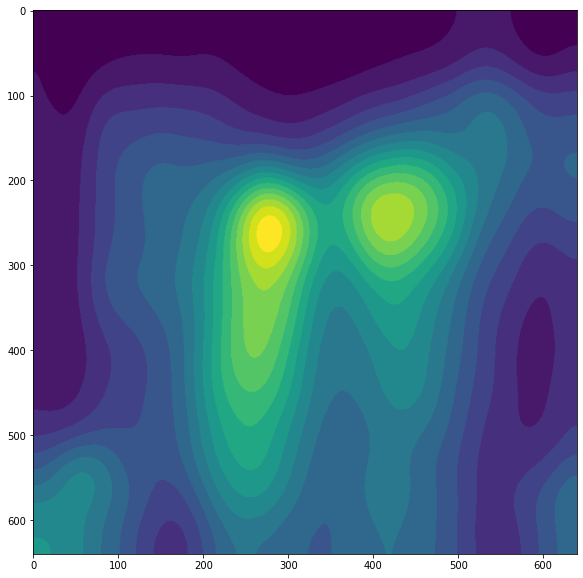

[(0, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (4, 2.641712948781452, 0.0, 0.0, 1.6417129487814521, 1, 79, 4), (5, 13.773651987269353, 0.2516368929881082, 54060.0, 1.624165274450806, 1, 78, 4), (3, 14.078695943858168, 0.3037953290639752, 69615.0, 1.624165274450806, 1, 77, 4), (45, 15.424910415147098, 0.6156918623901938, 195840.0, 1.624165274450806, 1, 76, 4), (1, 15.573727714402214, 0.6919176399551001, 238425.0, 1.5, 1, 75, 4), (18, 15.651059826975944, 0.6927638220805787, 238935.0, 1.5743491774985174, 1, 74, 4), (36, 15.67656065288749, 0.9313671875325171, 180499.0, 1.6417129487814521, 1, 73, 4), (8, 15.775407544757929, 1.0107845642200468, 231614.0, 1.4117955086337866, 1, 72, 4), (79, 15.987080904288755, 1.084533170742772, 243421.0, 1.5, 1, 71, 4), (27, 16.06236190066051, 0.7960811721072247, 309315.0, 1.624165274450806, 1, 70, 4), (2, 16.087657037017102, 0.8174289574464965, 326400.0, 1.5743491774985174, 1, 69, 4), (26, 16.12418847178784, 0.82774455008634, 335070.0, 1.

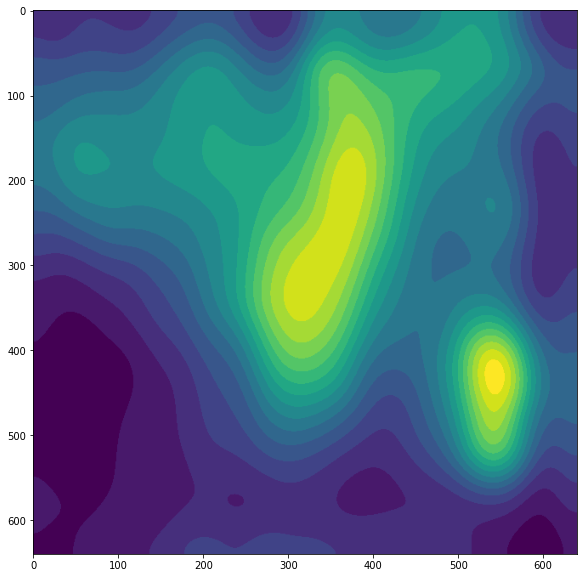

[(54, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 80, 4), (63, 14.115189965495372, 0.33413350815771137, 79305.0, 1.5, 1, 79, 4), (19, 14.846858970261229, 0.4491282034356685, 120615.0, 1.6973718331752026, 1, 78, 4), (45, 15.553721617775256, 0.6513258401641668, 214965.0, 1.624165274450806, 1, 77, 4), (76, 16.14077720554067, 0.8133935312796504, 323085.0, 1.6417129487814521, 1, 76, 4), (78, 16.151085292348494, 0.23756280119311857, 621054.0, 1.5743491774985174, 1, 75, 4), (73, 16.18321278980948, 0.3414392214161047, 622671.0, 1.5, 1, 74, 4), (65, 16.344712311552026, 1.0504427014780018, 295640.0, 1.6973718331752026, 1, 73, 4), (26, 16.358288546150078, 1.3918436919106187, 240890.0, 1.5743491774985174, 1, 72, 4), (80, 16.473131782915132, 1.408016986628054, 312800.0, 1.4117955086337866, 1, 71, 4), (35, 16.485232112460874, 1.4342936228168235, 249390.0, 1.624165274450806, 1, 70, 4), (72, 16.51987147018264, 0.968413087066464, 508725.0, 1.4117955086337866, 1, 69, 4), (77, 16.525467186751815

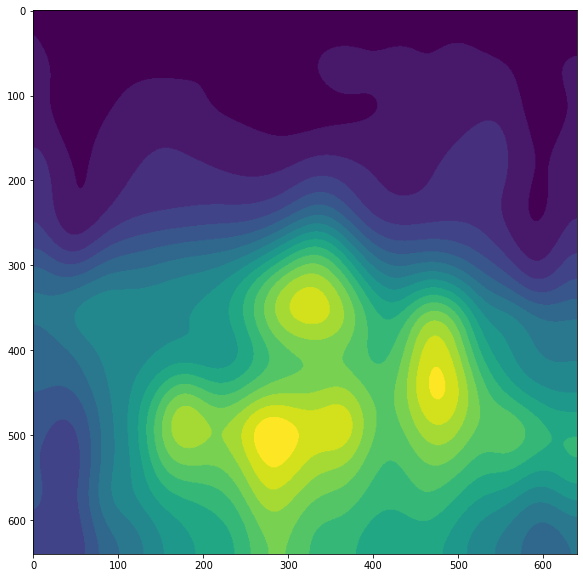

[(1, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (2, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (3, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 78, 4), (15, 2.6973718331752026, 0.0, 0.0, 1.6973718331752026, 1, 77, 4), (8, 13.52140895576316, 0.24533992283253842, 52275.0, 1.4117955086337866, 1, 76, 4), (4, 14.649208962739479, 0.4164990135676422, 108120.0, 1.6417129487814521, 1, 75, 4), (13, 14.714973057812557, 0.40058350568706336, 102255.0, 1.7791645796604998, 1, 74, 4), (0, 14.793681657778691, 0.5055683524884185, 143820.0, 1.4117955086337866, 1, 73, 4), (12, 15.30114771391445, 0.5468273221607025, 162180.0, 1.757858283255199, 1, 72, 4), (72, 15.356565251701038, 0.9073938943497033, 168953.0, 1.4117955086337866, 1, 71, 4), (7, 16.098683257584533, 0.8414447097746414, 347055.0, 1.5, 1, 70, 4), (17, 16.171914252137746, 0.861730578785599, 365925.0, 1.5, 1, 69, 4), (24, 16.199472967698362, 0.7847176444129444, 300645.0, 1.8010698775896221, 1, 68, 4), (63, 16.25097095174166, 1.189232

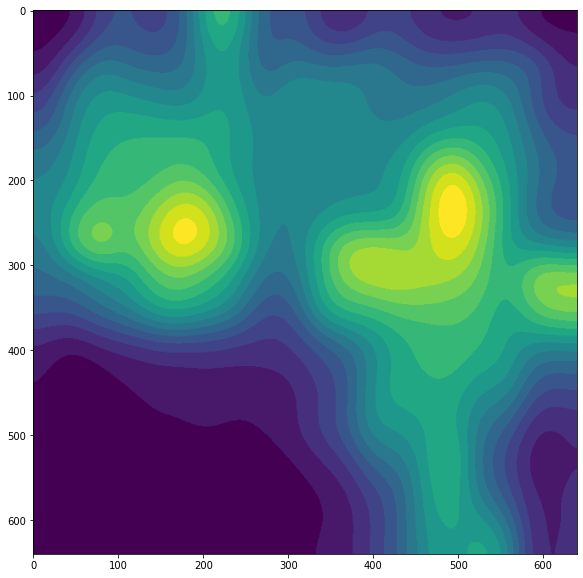

[(72, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (73, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (63, 2.5, 0.0, 0.0, 1.5, 1, 78, 4), (74, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 77, 4), (64, 2.6070974421975235, 0.0, 0.0, 1.6070974421975235, 1, 76, 4), (75, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 75, 4), (65, 2.6973718331752026, 0.0, 0.0, 1.6973718331752026, 1, 74, 4), (22, 2.8950250709279723, 0.0, 0.0, 1.8950250709279723, 1, 73, 4), (66, 12.668593737830783, 0.10679203237584184, 18105.0, 1.757858283255199, 1, 72, 4), (54, 12.987829706842785, 0.15371811289074744, 28560.0, 1.5743491774985174, 1, 71, 4), (23, 15.254800797898932, 0.5061609582979418, 144075.0, 1.8705505632961241, 1, 70, 4), (55, 16.022592143158153, 0.7637660565125991, 285345.0, 1.6973718331752026, 1, 69, 4), (76, 16.11631530516254, 0.8064480023238536, 317475.0, 1.6417129487814521, 1, 68, 4), (71, 16.25729263225502, 1.1951657353759115, 285537.0, 1.5, 1, 67, 4), (80, 16.898680927902703, 1.7118154

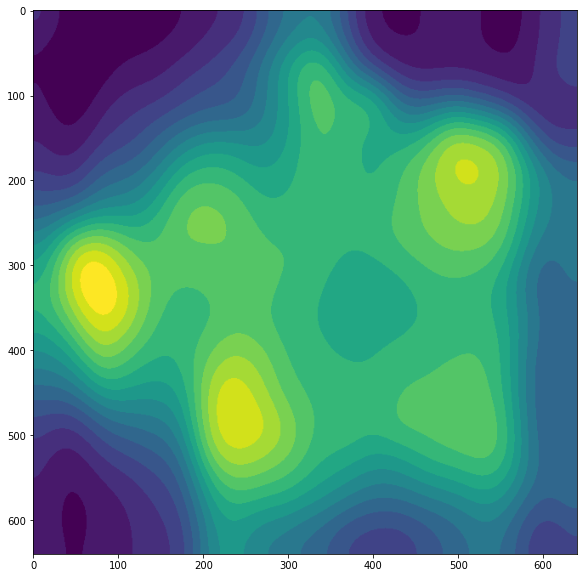

[(59, 2.870550563296124, 0.0, 0.0, 1.8705505632961241, 1, 80, 4), (1, 15.159875185635054, 0.5775816412867238, 176715.0, 1.5, 1, 79, 4), (0, 15.31834743526292, 0.885701039414613, 166184.0, 1.4117955086337866, 1, 78, 4), (41, 15.387305599311684, 0.5138132380685941, 147390.0, 1.9726549474122854, 1, 77, 4), (73, 16.145146071537273, 1.0737777476081507, 288188.0, 1.5, 1, 76, 4), (71, 16.338651638954964, 1.4314970189131009, 244545.0, 1.5, 1, 75, 4), (62, 16.39824411846909, 1.4139635055380566, 245225.0, 1.5743491774985174, 1, 74, 4), (9, 16.411131061127225, 0.9244499592671105, 436560.0, 1.5, 1, 73, 4), (7, 16.461220807076053, 1.0182951487258634, 417870.0, 1.5, 1, 72, 4), (31, 16.503731151749754, 0.16349785144089607, 638948.0, 1.9726549474122854, 1, 71, 4), (32, 16.506042372088807, 0.16447084924677352, 657049.0, 1.946057646725596, 1, 70, 4), (53, 16.53483637524348, 1.458656767672312, 255765.0, 1.624165274450806, 1, 69, 4), (50, 16.620850176859868, 0.8625204466948558, 366690.0, 1.946057646725596

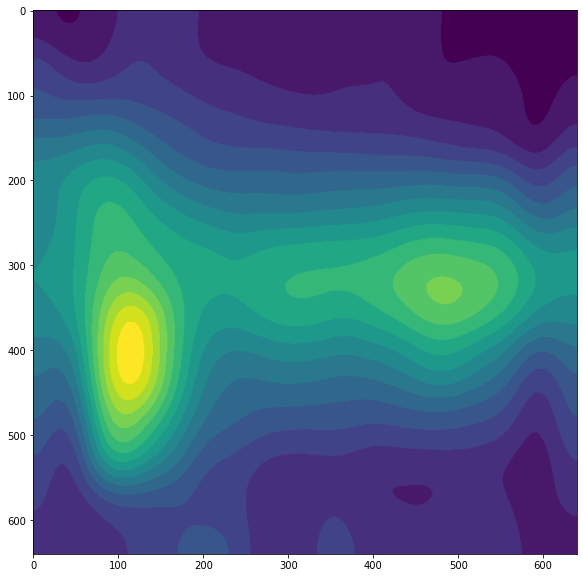

[(8, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (5, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 79, 4), (4, 2.641712948781452, 0.0, 0.0, 1.6417129487814521, 1, 78, 4), (3, 13.298299035735726, 0.18411032574832442, 35955.0, 1.624165274450806, 1, 77, 4), (72, 14.285607007121312, 0.3871273447225244, 97410.0, 1.4117955086337866, 1, 76, 4), (80, 14.914138173450958, 0.5362100957533565, 157335.0, 1.4117955086337866, 1, 75, 4), (76, 15.361415116259508, 0.5936472299339152, 184620.0, 1.6417129487814521, 1, 74, 4), (7, 15.497119104659815, 0.67026791449346, 225675.0, 1.5, 1, 73, 4), (17, 16.29300618525029, 1.0903031938598626, 328635.0, 1.5, 1, 72, 4), (16, 16.3753384917433, 0.339280130507783, 679397.0, 1.6070974421975235, 1, 71, 4), (2, 16.450610593268102, 0.7130824438654805, 520830.0, 1.5743491774985174, 1, 70, 4), (15, 16.46696163411556, 0.8881394204618134, 392955.0, 1.6973718331752026, 1, 69, 4), (74, 16.617694401959362, 0.9551075617858924, 483225.0, 1.5743491774985174,

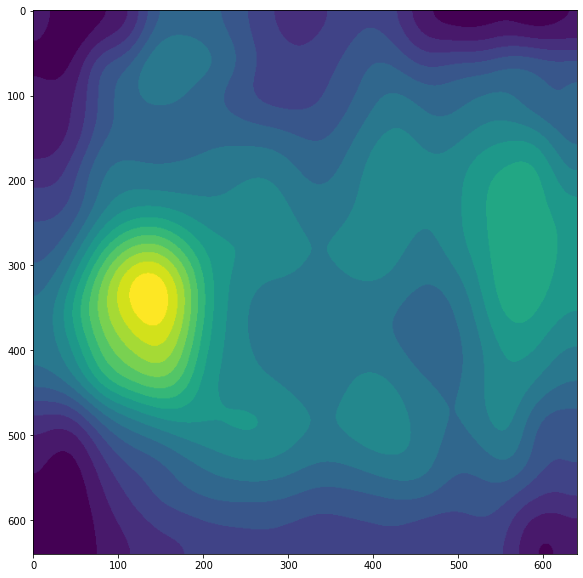

[(49, 2.9726549474122854, 0.0, 0.0, 1.9726549474122854, 1, 80, 4), (72, 12.984641397141841, 0.1717699389879554, 32895.0, 1.4117955086337866, 1, 79, 4), (51, 15.294433239724547, 0.5161486835385605, 148410.0, 1.8705505632961241, 1, 78, 4), (0, 15.315190655191838, 1.0479798726411718, 140845.0, 1.4117955086337866, 1, 77, 4), (40, 16.206348454261175, 0.7297144630876367, 262140.0, 2.0, 1, 76, 4), (63, 16.393144283661506, 1.366855824029642, 275485.0, 1.5, 1, 75, 4), (76, 16.402324669900455, 1.1490639675306658, 300003.0, 1.6417129487814521, 1, 74, 4), (78, 16.426476030884984, 1.2148336375484177, 307827.0, 1.5743491774985174, 1, 73, 4), (13, 16.454969007527957, 1.0339767477382946, 309226.0, 1.7791645796604998, 1, 72, 4), (77, 16.469499693172594, 1.1585871569861286, 323433.0, 1.624165274450806, 1, 71, 4), (20, 16.57583096541344, 1.0110632056200861, 349304.0, 1.8010698775896221, 1, 70, 4), (5, 16.62639585095013, 1.2166694901781865, 357025.0, 1.624165274450806, 1, 69, 4), (11, 16.67801556493869, 0

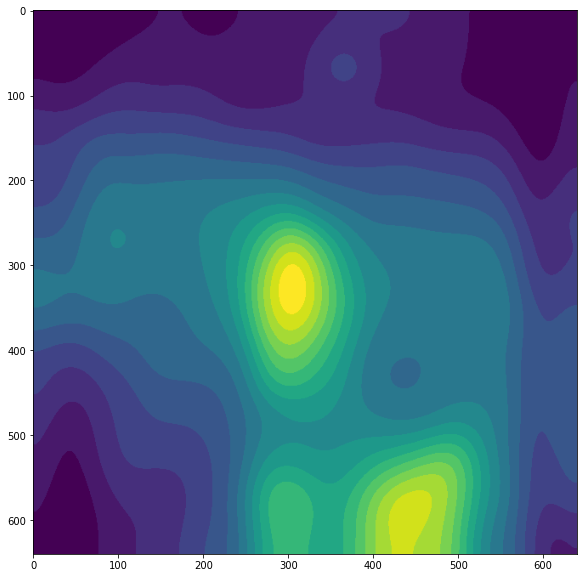

[(8, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (42, 2.8950250709279723, 0.0, 0.0, 1.8950250709279723, 1, 79, 4), (0, 10.690368777143165, 0.029259522248741024, 3825.0, 1.4117955086337866, 1, 78, 4), (72, 13.866326178041149, 0.3037953290639752, 69615.0, 1.4117955086337866, 1, 77, 4), (6, 14.098792530102497, 0.3167531193331222, 73695.0, 1.5743491774985174, 1, 76, 4), (17, 15.24967828860445, 0.6017645572478072, 188700.0, 1.5, 1, 75, 4), (29, 15.578856560051527, 0.5905728825487526, 183090.0, 1.8705505632961241, 1, 74, 4), (7, 15.64511173427506, 0.7122222920643809, 250920.0, 1.5, 1, 73, 4), (15, 15.65626018887726, 0.6595303061159012, 219555.0, 1.6973718331752026, 1, 72, 4), (4, 15.713690321006876, 0.9203978719916213, 189393.0, 1.6417129487814521, 1, 71, 4), (16, 16.286192302344496, 1.0265431304180221, 312560.0, 1.6070974421975235, 1, 70, 4), (62, 16.44805712890402, 0.41816919461772606, 697696.0, 1.5743491774985174, 1, 69, 4), (12, 16.56599961467613, 1.1964602547205008, 300

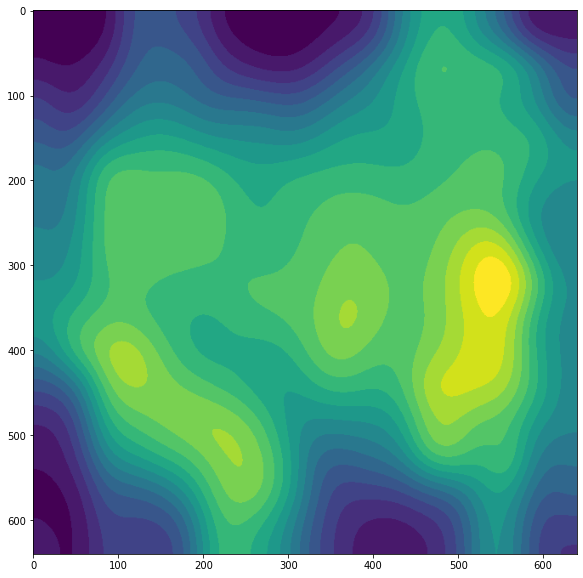

[(29, 2.870550563296124, 0.0, 0.0, 1.8705505632961241, 1, 80, 4), (0, 15.334754526884504, 0.6494847666250851, 213945.0, 1.4117955086337866, 1, 79, 4), (39, 16.224593901072616, 0.7427662067000221, 270810.0, 1.9726549474122854, 1, 78, 4), (48, 16.391291958897206, 0.9769281799557535, 259966.0, 1.946057646725596, 1, 77, 4), (72, 16.49756195880902, 1.4469540544020139, 308295.0, 1.4117955086337866, 1, 76, 4), (4, 16.539915857205624, 1.4632830086631115, 251430.0, 1.6417129487814521, 1, 75, 4), (38, 16.767486013150066, 0.9148189178707391, 424065.0, 1.8950250709279723, 1, 74, 4), (35, 16.86842393685467, 1.8749326071725485, 235467.0, 1.624165274450806, 1, 73, 4), (32, 16.92849905875719, 0.6454554841452338, 619697.0, 1.946057646725596, 1, 72, 4), (3, 16.933945662941024, 1.6243727862854256, 323000.0, 1.624165274450806, 1, 71, 4), (33, 16.962669112065605, 1.0760828212131839, 449565.0, 1.8705505632961241, 1, 70, 4), (25, 16.984816571149185, 0.9955664600451449, 592365.0, 1.6973718331752026, 1, 69, 4)

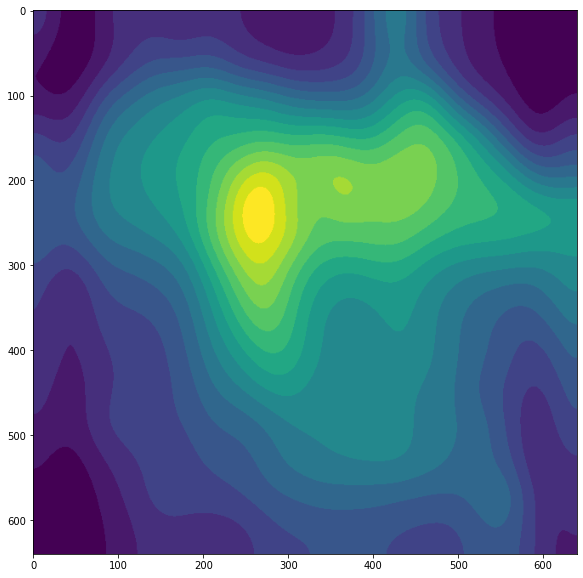

[(72, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (8, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 79, 4), (59, 2.870550563296124, 0.0, 0.0, 1.8705505632961241, 1, 78, 4), (50, 14.345733160014472, 0.2938915608077553, 66555.0, 1.946057646725596, 1, 77, 4), (71, 15.527575047034812, 0.9290709085378916, 179603.0, 1.5, 1, 76, 4), (65, 15.742455328083075, 0.6838035850753172, 233580.0, 1.6973718331752026, 1, 75, 4), (4, 16.03663954478115, 1.043996317553857, 231175.0, 1.6417129487814521, 1, 74, 4), (63, 16.07031906739732, 1.0153375559994695, 283504.0, 1.5, 1, 73, 4), (0, 16.124681248105205, 1.1926485482411397, 273823.0, 1.4117955086337866, 1, 72, 4), (17, 16.17184623168947, 1.3278176214065405, 229585.0, 1.5, 1, 71, 4), (54, 16.342170196897086, 0.8876693404012637, 392445.0, 1.5743491774985174, 1, 70, 4), (74, 16.5054159708385, 0.9293129423562165, 443190.0, 1.5743491774985174, 1, 69, 4), (27, 16.73550045119963, 0.9768653786827878, 506090.0, 1.624165274450806, 1, 68, 4), 

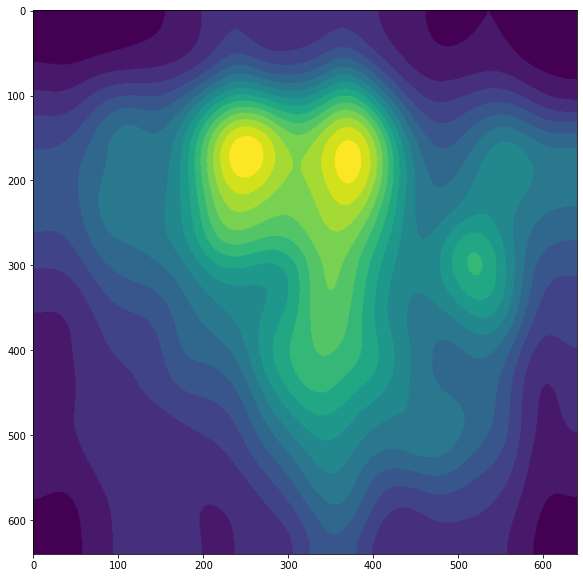

[(65, 12.96189083484967, 0.1382879778454706, 24990.0, 1.6973718331752026, 1, 80, 4), (8, 13.89734703757243, 0.3094983806109678, 71400.0, 1.4117955086337866, 1, 79, 4), (55, 14.99908376637688, 0.4856863668013145, 135405.0, 1.6973718331752026, 1, 78, 4), (0, 15.035814894622714, 0.5680431499579708, 172125.0, 1.4117955086337866, 1, 77, 4), (71, 15.335326708192163, 0.864242488344122, 158116.0, 1.5, 1, 76, 4), (78, 15.977348656786358, 0.995178537297902, 244708.0, 1.5743491774985174, 1, 75, 4), (1, 15.989821776928304, 1.0446967984845001, 254009.0, 1.5, 1, 74, 4), (80, 15.991265218376654, 1.072359573713754, 270252.0, 1.4117955086337866, 1, 73, 4), (72, 15.993028103207646, 0.8365635283323373, 342720.0, 1.4117955086337866, 1, 72, 4), (45, 16.027089255639066, 0.9686724827793355, 251262.0, 1.624165274450806, 1, 71, 4), (54, 16.34482233599208, 0.8883740592118605, 393210.0, 1.5743491774985174, 1, 70, 4), (4, 16.41515291848824, 1.536692639908696, 206230.0, 1.6417129487814521, 1, 69, 4), (63, 16.45778

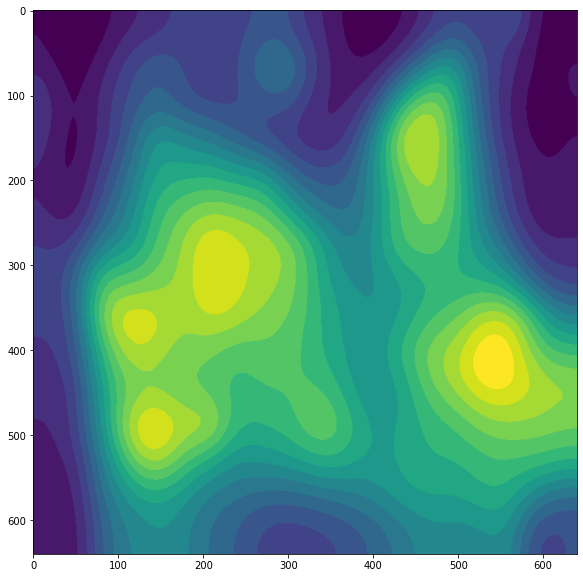

[(0, 15.260196336267505, 0.6287951678209591, 202725.0, 1.4117955086337866, 1, 80, 4), (72, 15.828996927428776, 1.2465746201991144, 193035.0, 1.4117955086337866, 1, 79, 4), (17, 15.997962154146652, 0.8130810062841034, 322830.0, 1.5, 1, 78, 4), (8, 16.187909841263554, 1.4148344227972123, 233580.0, 1.4117955086337866, 1, 77, 4), (5, 16.258732159044825, 1.2935045352921068, 228905.0, 1.624165274450806, 1, 76, 4), (50, 16.31200911191491, 0.7754330787750494, 293760.0, 1.946057646725596, 1, 75, 4), (35, 16.33240765112565, 1.5000968809837407, 200415.0, 1.624165274450806, 1, 74, 4), (59, 16.822063233992886, 1.4603926705375643, 265965.0, 1.8705505632961241, 1, 73, 4), (2, 16.82982981008888, 0.8588259400733356, 657799.0, 1.5743491774985174, 1, 72, 4), (26, 16.837414245777047, 1.0604460827886446, 541782.0, 1.5743491774985174, 1, 71, 4), (63, 16.915128684266932, 1.9508272365952097, 258927.0, 1.5, 1, 70, 4), (3, 16.994523600939253, 1.4283544320045443, 417485.0, 1.624165274450806, 1, 69, 4), (48, 17.0

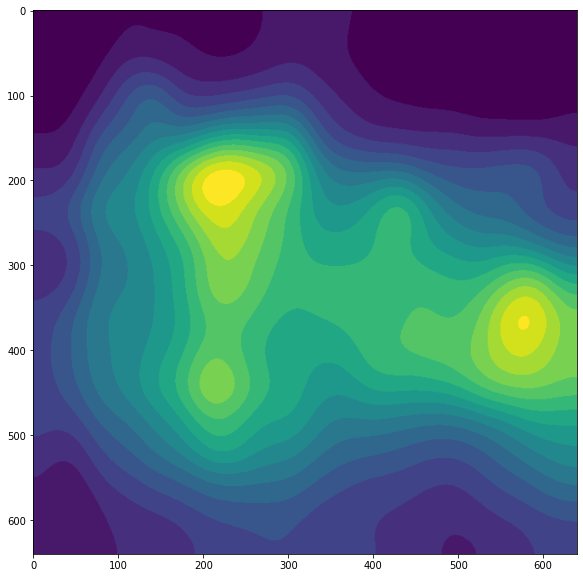

[(8, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (0, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 79, 4), (7, 2.5, 0.0, 0.0, 1.5, 1, 78, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 77, 4), (72, 7.955785109371328, 0.002726055579115115, 255.0, 1.4117955086337866, 1, 76, 4), (4, 14.178882627415657, 0.31915233120749775, 74460.0, 1.6417129487814521, 1, 75, 4), (9, 15.257606488362098, 0.9950903020628115, 128350.0, 1.5, 1, 74, 4), (17, 15.790984056828444, 0.7539543553651675, 278460.0, 1.5, 1, 73, 4), (16, 15.950980653247317, 0.7691131816036714, 289170.0, 1.6070974421975235, 1, 72, 4), (5, 16.14399508362805, 0.8192743592212514, 327930.0, 1.624165274450806, 1, 71, 4), (15, 16.170913726998783, 1.017757770718474, 256731.0, 1.6973718331752026, 1, 70, 4), (3, 16.306993350622406, 1.0368760134512407, 310504.0, 1.624165274450806, 1, 69, 4), (76, 16.451309944721366, 1.1855215026036146, 303785.0, 1.6417129487814521, 1, 68, 4), (77, 16.5195496443891, 0.7403602102

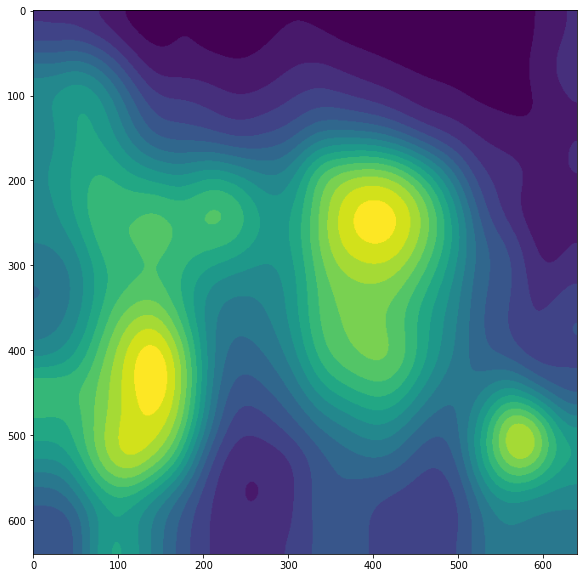

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (78, 10.919115620071114, 0.030914175174389536, 4080.0, 1.5743491774985174, 1, 79, 4), (6, 12.76890201627495, 0.13150071656896684, 23460.0, 1.5743491774985174, 1, 78, 4), (26, 14.825301867877089, 0.473319555016442, 130305.0, 1.5743491774985174, 1, 77, 4), (35, 15.277825536330095, 0.802720892126276, 140216.0, 1.624165274450806, 1, 76, 4), (53, 15.284504969725802, 0.8125432750505277, 139776.0, 1.624165274450806, 1, 75, 4), (5, 15.865542627242586, 0.9410587298834988, 219766.0, 1.624165274450806, 1, 74, 4), (80, 16.08469182592338, 1.1698573318095842, 269154.0, 1.4117955086337866, 1, 73, 4), (75, 16.139742758161244, 0.15984936973399128, 631421.0, 1.624165274450806, 1, 72, 4), (3, 16.337615731784965, 0.873065449464931, 377145.0, 1.624165274450806, 1, 71, 4), (16, 16.364416620029026, 1.1333852419900032, 303742.0, 1.6070974421975235, 1, 70, 4), (2, 16.81730824482827, 0.9905942703311676, 569415.0, 1.5743491774985174, 1, 69, 4), (72, 16.86712031315577, 1.853036

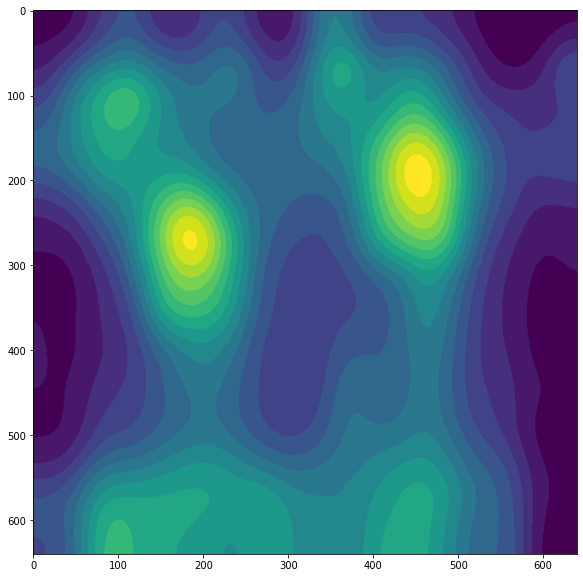

[(49, 14.219514804392029, 0.26751700289812125, 58650.0, 1.9726549474122854, 1, 80, 4), (40, 14.964279716346399, 0.4068590114896186, 104550.0, 2.0, 1, 79, 4), (21, 15.593574079395708, 0.9880350834353908, 124865.0, 1.8705505632961241, 1, 78, 4), (62, 15.941207692810197, 0.9860723474931755, 238181.0, 1.5743491774985174, 1, 77, 4), (35, 15.997227195692613, 1.0031754349734179, 235599.0, 1.624165274450806, 1, 76, 4), (53, 16.024941791566988, 0.7853961557603953, 301155.0, 1.624165274450806, 1, 75, 4), (58, 16.125318111554876, 1.010884711911699, 202685.0, 1.8950250709279723, 1, 74, 4), (22, 16.26392573129221, 1.0549202461815455, 222789.0, 1.8950250709279723, 1, 73, 4), (36, 16.265925541284304, 1.1279360569773889, 267340.0, 1.6417129487814521, 1, 72, 4), (7, 16.617446480937247, 1.6804367328632002, 251956.0, 1.5, 1, 71, 4), (71, 16.634901905385387, 1.5618971014638334, 288660.0, 1.5, 1, 70, 4), (44, 16.648661144965192, 0.9470774342100624, 469710.0, 1.6417129487814521, 1, 69, 4), (8, 16.7017979664

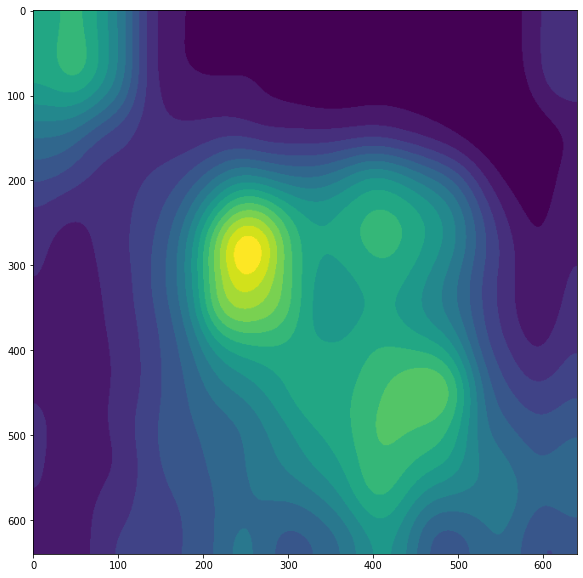

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (16, 2.6070974421975235, 0.0, 0.0, 1.6070974421975235, 1, 78, 4), (45, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 77, 4), (5, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 76, 4), (3, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 75, 4), (4, 2.641712948781452, 0.0, 0.0, 1.6417129487814521, 1, 74, 4), (72, 13.027848844558056, 0.17694999081493185, 34170.0, 1.4117955086337866, 1, 73, 4), (36, 14.35712328810451, 0.3540638638122713, 85935.0, 1.6417129487814521, 1, 72, 4), (54, 14.60598075777508, 0.4219424468740272, 110160.0, 1.5743491774985174, 1, 71, 4), (44, 15.257647700512928, 0.5659020696013675, 171105.0, 1.6417129487814521, 1, 70, 4), (15, 15.360243441696896, 0.7908461424422353, 143204.0, 1.6973718331752026, 1, 69, 4), (63, 15.419649391740853, 0.6485617760929515, 213435.0, 1.5, 1, 68, 4), (19, 16.10887218324039, 1.0669404873203396, 229707.0, 1.6973718331752026, 1, 6

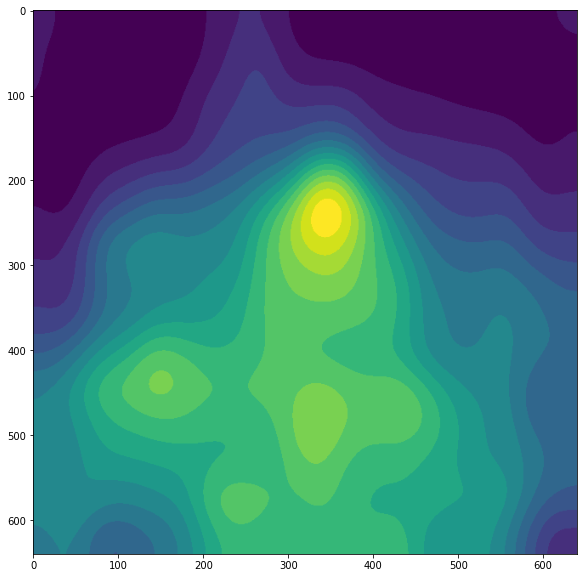

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (1, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 78, 4), (10, 2.6070974421975235, 0.0, 0.0, 1.6070974421975235, 1, 77, 4), (17, 11.990071407980706, 0.07760685191438932, 12240.0, 1.5, 1, 76, 4), (9, 13.362130466338115, 0.20887913282314607, 42330.0, 1.5, 1, 75, 4), (5, 13.947113155759189, 0.2804261256052288, 62475.0, 1.624165274450806, 1, 74, 4), (18, 14.5069596434377, 0.39988237367277424, 102000.0, 1.5743491774985174, 1, 73, 4), (8, 14.561282645719814, 0.4491282034356685, 120615.0, 1.4117955086337866, 1, 72, 4), (76, 14.771730842024748, 0.4445687139592245, 118830.0, 1.6417129487814521, 1, 71, 4), (63, 15.266281952013001, 0.6062794233373552, 190995.0, 1.5, 1, 70, 4), (2, 15.689294648996881, 0.7036285145418116, 245565.0, 1.5743491774985174, 1, 69, 4), (62, 15.800991019917797, 0.7355218422600811, 265965.0, 1.5743491774985174, 1, 68, 4), (0, 16.025677552171143, 0.8456824798856408, 350880.0, 1.4117955086337866, 1,

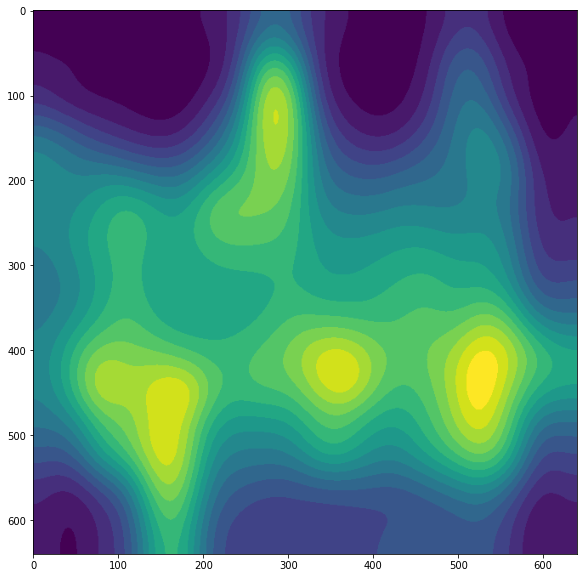

[(1, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (8, 13.348622563611016, 0.21941377724497407, 45135.0, 1.4117955086337866, 1, 79, 4), (38, 13.404731383010585, 0.16442172219093046, 31110.0, 1.8950250709279723, 1, 78, 4), (78, 14.632644800519973, 0.6208051641713175, 92734.0, 1.5743491774985174, 1, 77, 4), (0, 15.035814894622714, 0.5680431499579708, 172125.0, 1.4117955086337866, 1, 76, 4), (2, 15.14084787328186, 0.5528888561240181, 164985.0, 1.5743491774985174, 1, 75, 4), (80, 15.146808354088474, 0.9885183636866649, 126310.0, 1.4117955086337866, 1, 74, 4), (76, 15.226939861829711, 0.5578025789457455, 167280.0, 1.6417129487814521, 1, 73, 4), (5, 15.268209326026497, 0.5733616681550395, 174675.0, 1.624165274450806, 1, 72, 4), (17, 15.70305327995706, 1.1730915174441303, 167705.0, 1.5, 1, 71, 4), (10, 16.179834417006166, 1.3024461719519052, 213265.0, 1.6070974421975235, 1, 70, 4), (75, 16.205724954264237, 1.311268876956692, 213265.0, 1.624165274450806, 1, 69, 4), (72, 16.304656644961387, 0.9177340648898896

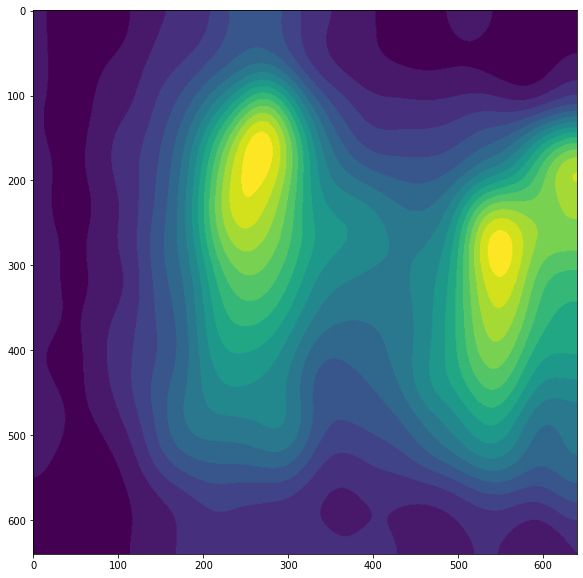

[(72, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (8, 14.255289498456678, 0.38065202502065054, 95115.0, 1.4117955086337866, 1, 79, 4), (6, 14.477857281054176, 0.3935369984118654, 99705.0, 1.5743491774985174, 1, 78, 4), (78, 15.41144049732498, 0.8257934515600568, 164604.0, 1.5743491774985174, 1, 77, 4), (0, 15.836080764074346, 0.7921118882021477, 306255.0, 1.4117955086337866, 1, 76, 4), (9, 15.900776517116183, 0.7853961557603953, 301155.0, 1.5, 1, 75, 4), (63, 15.996859125735853, 0.8127681794158057, 322575.0, 1.5, 1, 74, 4), (75, 16.01542316833062, 0.7826745000679117, 299115.0, 1.624165274450806, 1, 73, 4), (41, 16.146457856757266, 0.9199596668464628, 209786.0, 1.9726549474122854, 1, 72, 4), (7, 16.161301541630273, 0.8588129044999242, 363120.0, 1.5, 1, 71, 4), (1, 16.517161457634266, 1.1886887193406541, 372679.0, 1.5, 1, 70, 4), (73, 16.55537126404377, 0.957679749445089, 487815.0, 1.5, 1, 69, 4), (5, 16.60100257987822, 0.8528372680819416, 500819.0, 1.624165274450806, 1,

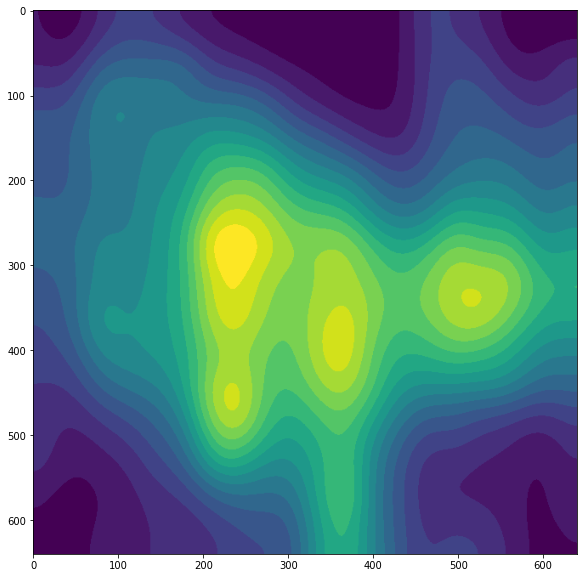

[(5, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 80, 4), (72, 14.203301956555913, 0.36970991636299927, 91290.0, 1.4117955086337866, 1, 79, 4), (4, 14.379281076274957, 0.35857413516913894, 87465.0, 1.6417129487814521, 1, 78, 4), (74, 15.456126901996415, 1.0483279462719057, 137785.0, 1.5743491774985174, 1, 77, 4), (19, 15.600362233459567, 0.643922160102248, 210885.0, 1.6973718331752026, 1, 76, 4), (8, 16.159651735217437, 1.1865421641237828, 285305.0, 1.4117955086337866, 1, 75, 4), (18, 16.359938245770344, 1.1893680187453823, 295440.0, 1.5743491774985174, 1, 74, 4), (14, 16.46896964678729, 1.344387782118357, 234855.0, 1.757858283255199, 1, 73, 4), (28, 16.598584279451536, 1.0889974066635708, 345148.0, 1.757858283255199, 1, 72, 4), (40, 16.66375396302523, 1.017344683843556, 310646.0, 2.0, 1, 71, 4), (73, 16.684982976043166, 0.7196868475840089, 704537.0, 1.5, 1, 70, 4), (70, 16.74987906721434, 1.2980787046231939, 378777.0, 1.6070974421975235, 1, 69, 4), (80, 16.755488789896557, 0.99

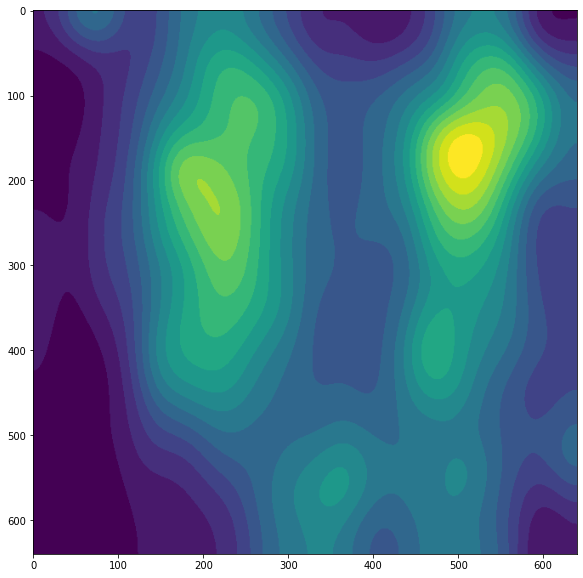

[(72, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (63, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (54, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 78, 4), (41, 14.599777535744566, 0.3364660572656016, 80070.0, 1.9726549474122854, 1, 77, 4), (74, 15.224349328665951, 0.5749477680756656, 175440.0, 1.5743491774985174, 1, 76, 4), (50, 15.522666050258357, 0.7644231473006975, 134886.0, 1.946057646725596, 1, 75, 4), (9, 15.613493262941317, 0.7032152671171836, 245310.0, 1.5, 1, 74, 4), (18, 15.832307686920716, 0.9431749670345789, 222968.0, 1.5743491774985174, 1, 73, 4), (45, 16.301829224137432, 0.863307808528677, 367455.0, 1.624165274450806, 1, 72, 4), (73, 16.368432521063383, 0.9138016402097179, 422790.0, 1.5, 1, 71, 4), (62, 16.473705308154056, 1.1077020276846843, 359207.0, 1.5743491774985174, 1, 70, 4), (44, 16.543658266944288, 1.447938952511232, 256275.0, 1.6417129487814521, 1, 69, 4), (36, 16.585099875360218, 0.6221464612650598, 610016.0, 1.6417129487814521, 1, 68, 4), (80, 16

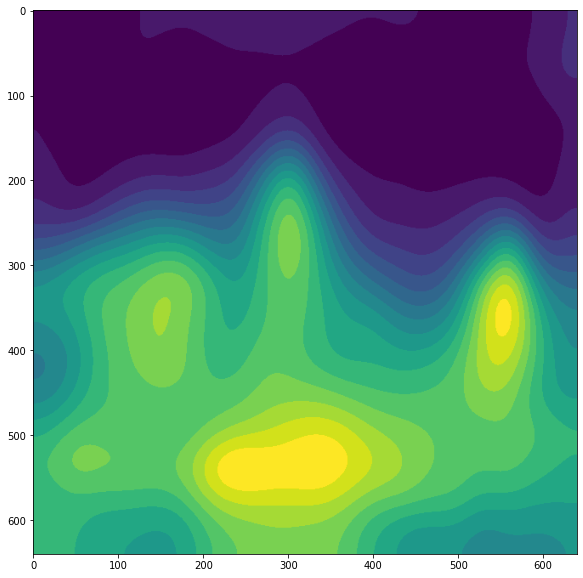

[(0, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (7, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (16, 2.6070974421975235, 0.0, 0.0, 1.6070974421975235, 1, 78, 4), (10, 2.6070974421975235, 0.0, 0.0, 1.6070974421975235, 1, 77, 4), (15, 2.6973718331752026, 0.0, 0.0, 1.6973718331752026, 1, 76, 4), (11, 2.6973718331752026, 0.0, 0.0, 1.6973718331752026, 1, 75, 4), (14, 2.757858283255199, 0.0, 0.0, 1.757858283255199, 1, 74, 4), (9, 9.846301770024223, 0.01327875563774009, 1530.0, 1.5, 1, 73, 4), (24, 14.03745305848323, 0.26577400678074053, 58140.0, 1.8010698775896221, 1, 72, 4), (6, 14.458127179254994, 0.38927112231026845, 98175.0, 1.5743491774985174, 1, 71, 4), (1, 14.722283725097629, 0.46641208151701247, 127500.0, 1.5, 1, 70, 4), (12, 15.658466295202583, 0.8875862774242496, 164888.0, 1.757858283255199, 1, 69, 4), (25, 15.800658943073566, 0.7003122242592078, 243525.0, 1.6973718331752026, 1, 68, 4), (5, 15.827786064567995, 0.7289342192280479, 261630.0, 1.624165274450806, 1, 67, 4), (72, 16

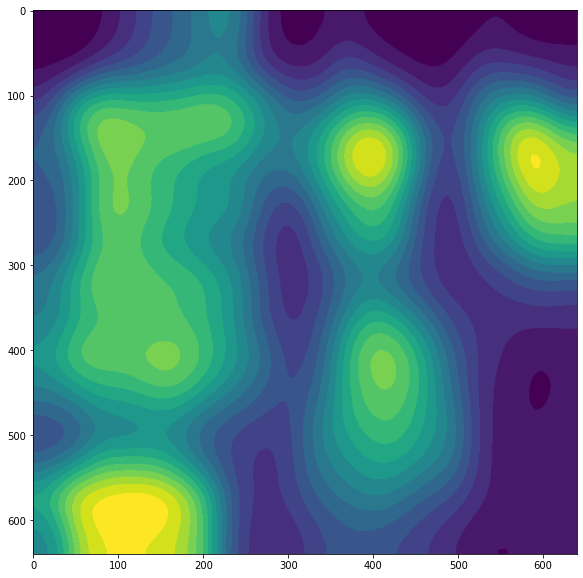

[(80, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (71, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (6, 14.910956364497604, 0.6958779509570614, 113633.0, 1.5743491774985174, 1, 78, 4), (0, 15.041450101174414, 0.951384194983561, 117980.0, 1.4117955086337866, 1, 77, 4), (46, 16.534484289576827, 0.3967145591030986, 646877.0, 1.757858283255199, 1, 76, 4), (8, 16.57807463080916, 1.5697027336771956, 295545.0, 1.4117955086337866, 1, 75, 4), (79, 16.73275123659106, 1.027610432729164, 543150.0, 1.5, 1, 74, 4), (43, 16.79740685444851, 1.663659110994622, 232021.0, 1.7791645796604998, 1, 73, 4), (4, 16.95429753180223, 1.5140832855229838, 361675.0, 1.6417129487814521, 1, 72, 4), (77, 16.974666653161297, 1.6031078525794036, 343655.0, 1.624165274450806, 1, 71, 4), (73, 16.99273097796524, 0.5712400964637344, 1111800.0, 1.5, 1, 70, 4), (62, 17.112782755105478, 0.6586251524599571, 1066410.0, 1.5743491774985174, 1, 69, 4), (53, 17.1187801371752, 0.8704621662564451, 825837.0, 1.624165274450806, 1, 68, 

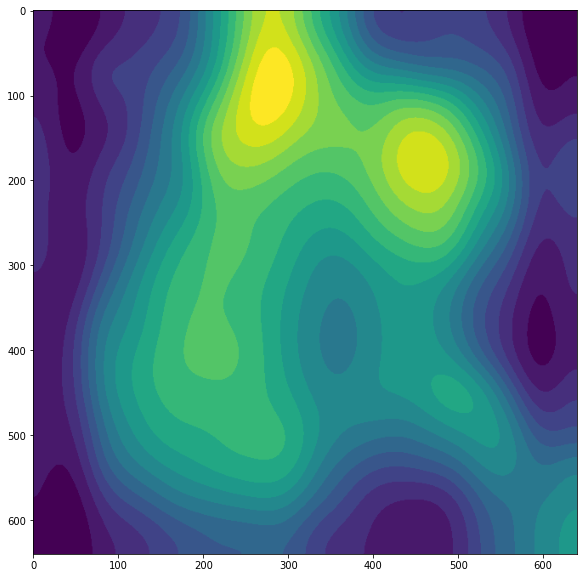

[(72, 14.062401215029782, 0.501624399340113, 69493.0, 1.4117955086337866, 1, 80, 4), (8, 15.212813382503532, 0.8617076505388489, 153171.0, 1.4117955086337866, 1, 79, 4), (78, 15.36133477951759, 0.8343804151629409, 155221.0, 1.5743491774985174, 1, 78, 4), (0, 15.72160619849561, 0.9534146793387782, 232442.0, 1.4117955086337866, 1, 77, 4), (36, 15.802627498903556, 1.1607903920170406, 162775.0, 1.6417129487814521, 1, 76, 4), (9, 16.615185090280754, 1.1229235645338138, 439003.0, 1.5, 1, 75, 4), (27, 16.632514116739696, 0.9473928930139224, 470220.0, 1.624165274450806, 1, 74, 4), (53, 16.695228256483933, 1.0892659704657695, 434433.0, 1.624165274450806, 1, 73, 4), (57, 16.772000325811135, 0.5637653500536202, 620130.0, 1.8705505632961241, 1, 72, 4), (63, 16.861426425527632, 1.5955637215337424, 350061.0, 1.5, 1, 71, 4), (56, 16.916075190533007, 0.9702172586253617, 511339.0, 1.8010698775896221, 1, 70, 4), (44, 16.993537449688386, 1.208159620082687, 510765.0, 1.6417129487814521, 1, 69, 4), (54, 17

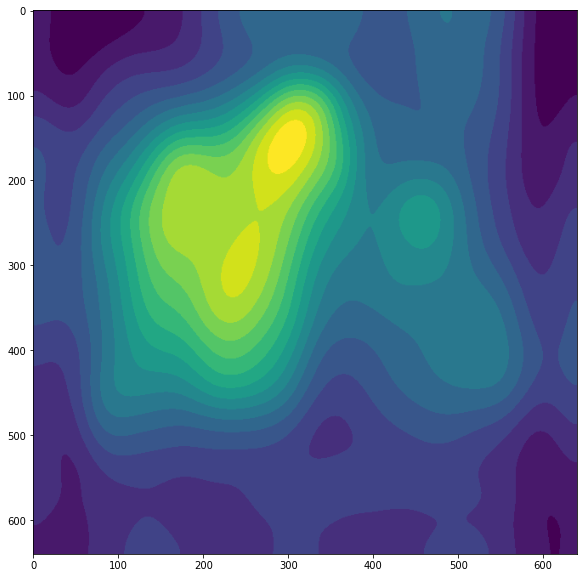

[(36, 14.996415307986561, 0.6903957603475632, 116344.0, 1.6417129487814521, 1, 80, 4), (69, 15.067381586766109, 0.5025967352773811, 142545.0, 1.6973718331752026, 1, 79, 4), (74, 15.465566883831, 0.6406498209157576, 209100.0, 1.5743491774985174, 1, 78, 4), (4, 15.5825162144042, 0.9107997640208554, 167712.0, 1.6417129487814521, 1, 77, 4), (75, 15.641588357445215, 0.6759894695337829, 228990.0, 1.624165274450806, 1, 76, 4), (71, 15.695406525630736, 0.7265850741939934, 260100.0, 1.5, 1, 75, 4), (5, 15.85790415862829, 0.9428013303408883, 217714.0, 1.624165274450806, 1, 74, 4), (73, 15.890063379499217, 0.7823328642038339, 298860.0, 1.5, 1, 73, 4), (72, 16.085629375871044, 0.8622574359998054, 366435.0, 1.4117955086337866, 1, 72, 4), (8, 16.17604204476883, 1.2104226446871793, 283176.0, 1.4117955086337866, 1, 71, 4), (26, 16.246263429636265, 0.861730578785599, 365925.0, 1.5743491774985174, 1, 70, 4), (63, 16.281251409924934, 0.9278792065288971, 382075.0, 1.5, 1, 69, 4), (0, 16.30889003868377, 0.

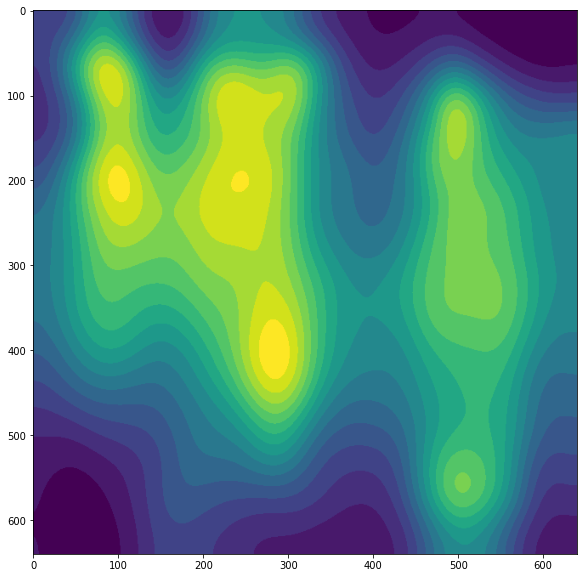

[(72, 13.778431228394671, 0.2880379075839226, 64770.0, 1.4117955086337866, 1, 80, 4), (8, 14.703492145822059, 0.48323254348848343, 134385.0, 1.4117955086337866, 1, 79, 4), (77, 16.007303743480666, 1.0226594620760412, 233393.0, 1.624165274450806, 1, 78, 4), (30, 16.84775484241508, 0.7581360861690402, 510712.0, 1.946057646725596, 1, 77, 4), (26, 16.85242045237769, 1.1907135066736572, 482800.0, 1.5743491774985174, 1, 76, 4), (80, 16.91511268106154, 1.969957199853439, 277440.0, 1.4117955086337866, 1, 75, 4), (63, 17.03488337522378, 1.3211046658243422, 547862.0, 1.5, 1, 74, 4), (76, 17.08303746669603, 1.6454117616903878, 360740.0, 1.6417129487814521, 1, 73, 4), (7, 17.096011572306395, 2.1495489536535426, 254349.0, 1.5, 1, 72, 4), (5, 17.099329983225843, 1.7744537499158501, 327981.0, 1.624165274450806, 1, 71, 4), (35, 17.106147454128042, 1.7027008355497726, 354790.0, 1.624165274450806, 1, 70, 4), (21, 17.167597000264653, 0.9907993901703571, 600938.0, 1.8705505632961241, 1, 69, 4), (74, 17.17

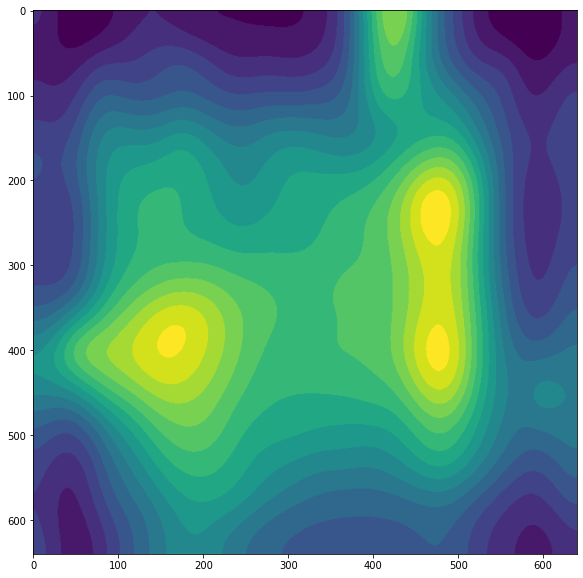

[(49, 12.129031683867177, 0.05976512980705059, 8925.0, 1.9726549474122854, 1, 80, 4), (77, 16.12136872549448, 0.9979053758955722, 268149.0, 1.624165274450806, 1, 79, 4), (8, 16.167431980291582, 1.1057822597352533, 311718.0, 1.4117955086337866, 1, 78, 4), (27, 16.484291586334486, 1.4354001803121614, 248880.0, 1.624165274450806, 1, 77, 4), (40, 16.558311435864915, 0.17824695735118806, 646976.0, 2.0, 1, 76, 4), (0, 16.691436767630606, 1.2258137146802617, 466880.0, 1.4117955086337866, 1, 75, 4), (72, 16.78671828091165, 1.3896972830921703, 435925.0, 1.4117955086337866, 1, 74, 4), (35, 16.79951601468207, 0.9805922854115858, 537540.0, 1.624165274450806, 1, 73, 4), (30, 16.84276704102055, 1.1165462270750481, 355103.0, 1.946057646725596, 1, 72, 4), (76, 16.853401399012995, 1.4608381305347797, 344845.0, 1.6417129487814521, 1, 71, 4), (62, 16.962973893600356, 0.8650211429759131, 746838.0, 1.5743491774985174, 1, 70, 4), (80, 17.013664210910832, 1.5833780589377597, 450670.0, 1.4117955086337866, 1, 

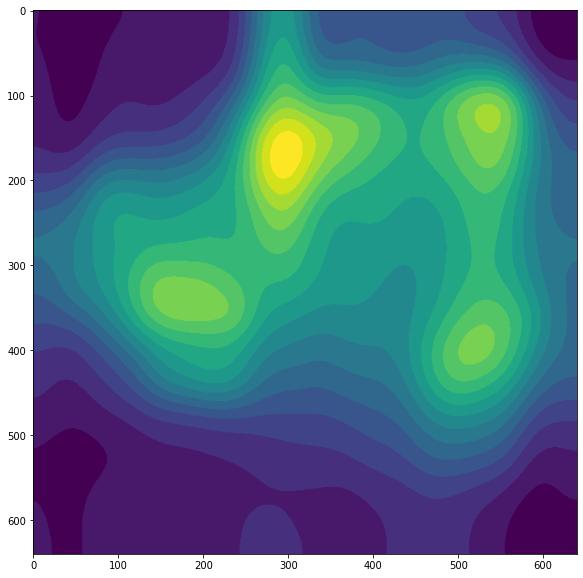

[(73, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (74, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (2, 9.92065094752274, 0.01327875563774009, 1530.0, 1.5743491774985174, 1, 78, 4), (80, 13.626977299367116, 0.26227219371986327, 57120.0, 1.4117955086337866, 1, 77, 4), (78, 13.805463279551745, 0.2649005394133981, 57885.0, 1.5743491774985174, 1, 76, 4), (63, 14.373811498487525, 0.3871273447225244, 97410.0, 1.5, 1, 75, 4), (0, 14.874296378886841, 0.5259757269791774, 152745.0, 1.4117955086337866, 1, 74, 4), (33, 16.090968875643174, 0.9317984058493108, 217210.0, 1.8705505632961241, 1, 73, 4), (76, 16.213608509343093, 0.8339454445688642, 340425.0, 1.6417129487814521, 1, 72, 4), (65, 16.21611691571735, 0.8189675400544005, 327675.0, 1.6973718331752026, 1, 71, 4), (77, 16.251071293975098, 0.8493031316115198, 354195.0, 1.624165274450806, 1, 70, 4), (6, 16.395595304917265, 1.430209585816533, 240635.0, 1.5743491774985174, 1, 69, 4), (72, 16.42154284178922, 0.9477073729342066, 470730.0, 1.4117955

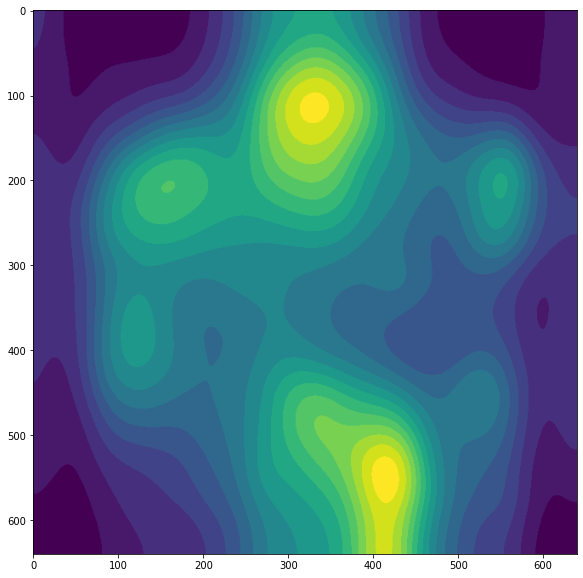

[(72, 12.594277167293622, 0.1303586069845603, 23205.0, 1.4117955086337866, 1, 80, 4), (7, 13.638215977721154, 0.24984490184525998, 53550.0, 1.5, 1, 79, 4), (51, 14.727597439234598, 0.3835381433320379, 96135.0, 1.8705505632961241, 1, 78, 4), (1, 14.816610688419262, 0.48934904875197066, 136935.0, 1.5, 1, 77, 4), (54, 15.971031504200866, 1.255548282331085, 187425.0, 1.5743491774985174, 1, 76, 4), (36, 16.0321864866861, 1.2264736687963829, 191760.0, 1.6417129487814521, 1, 75, 4), (74, 16.239132798604732, 1.1520391060851045, 271779.0, 1.5743491774985174, 1, 74, 4), (71, 16.304381804462885, 1.2321463673072872, 288438.0, 1.5, 1, 73, 4), (17, 16.317266081663362, 1.1097486753979522, 330221.0, 1.5, 1, 72, 4), (80, 16.352146329802288, 1.449230821009301, 265965.0, 1.4117955086337866, 1, 71, 4), (9, 16.36831093111516, 0.6299385351370962, 561503.0, 1.5, 1, 70, 4), (18, 16.558432203014828, 1.4400250030251132, 280424.0, 1.5743491774985174, 1, 69, 4), (44, 16.575634298804108, 1.0713084559897321, 385622

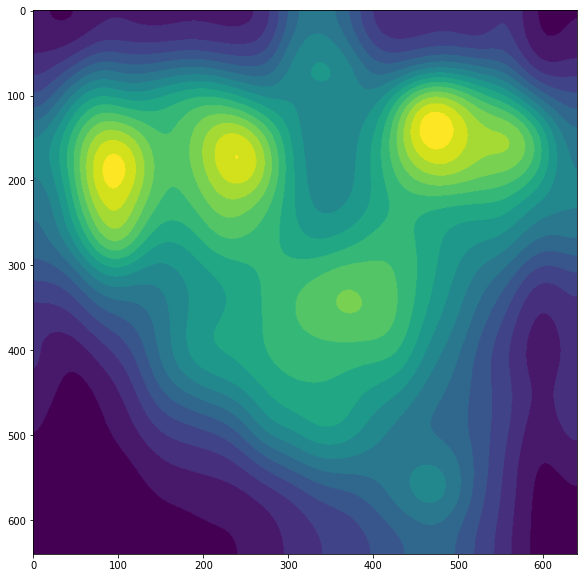

[(72, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (73, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (63, 2.5, 0.0, 0.0, 1.5, 1, 78, 4), (80, 15.925103368152373, 0.8174289574464965, 326400.0, 1.4117955086337866, 1, 77, 4), (74, 16.214143508131958, 0.8528757178804776, 357510.0, 1.5743491774985174, 1, 76, 4), (64, 16.243975823872898, 1.145085587006958, 266144.0, 1.6070974421975235, 1, 75, 4), (45, 16.399970476299643, 1.3338109926452386, 253215.0, 1.624165274450806, 1, 74, 4), (53, 16.452173273194795, 1.04370531889721, 356576.0, 1.624165274450806, 1, 73, 4), (54, 16.540459801002683, 0.9376733841320013, 455175.0, 1.5743491774985174, 1, 72, 4), (71, 16.824254154894273, 1.1125803786108852, 546710.0, 1.5, 1, 71, 4), (13, 16.877599324245264, 1.1850112695989454, 405722.0, 1.7791645796604998, 1, 70, 4), (75, 16.95375099900387, 0.993439268688133, 619177.0, 1.624165274450806, 1, 69, 4), (62, 17.040849784272048, 0.9917986739876146, 711195.0, 1.5743491774985174, 1, 68, 4), (77, 17.047414892000777,

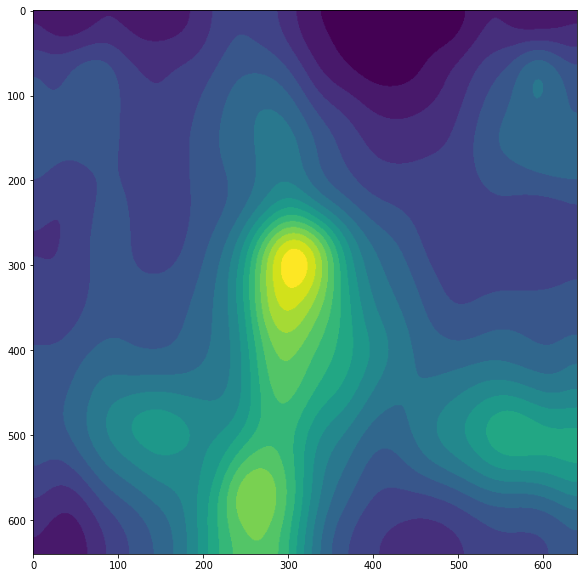

[(34, 13.448103579252887, 0.18613712057935536, 36465.0, 1.757858283255199, 1, 80, 4), (5, 14.190586625751612, 0.324714232751694, 76245.0, 1.624165274450806, 1, 79, 4), (6, 14.998114403788518, 0.7143441329699357, 121713.0, 1.5743491774985174, 1, 78, 4), (35, 15.059509127676526, 0.5190554882391964, 149685.0, 1.624165274450806, 1, 77, 4), (33, 15.703896069052272, 0.8490985303272401, 160211.0, 1.8705505632961241, 1, 76, 4), (43, 16.313014017917297, 0.823235876427771, 331245.0, 1.7791645796604998, 1, 75, 4), (54, 16.487133839907546, 1.2384442684027377, 319445.0, 1.5743491774985174, 1, 74, 4), (72, 16.554405299541134, 1.2514851425315896, 396775.0, 1.4117955086337866, 1, 73, 4), (29, 16.587162732442813, 1.1252227025379717, 294016.0, 1.8705505632961241, 1, 72, 4), (17, 16.588853672675388, 0.8005589945400862, 590246.0, 1.5, 1, 71, 4), (78, 16.61941091048439, 1.2636799440646902, 355536.0, 1.5743491774985174, 1, 70, 4), (27, 16.66983266839632, 0.8514876681525929, 537229.0, 1.624165274450806, 1, 6

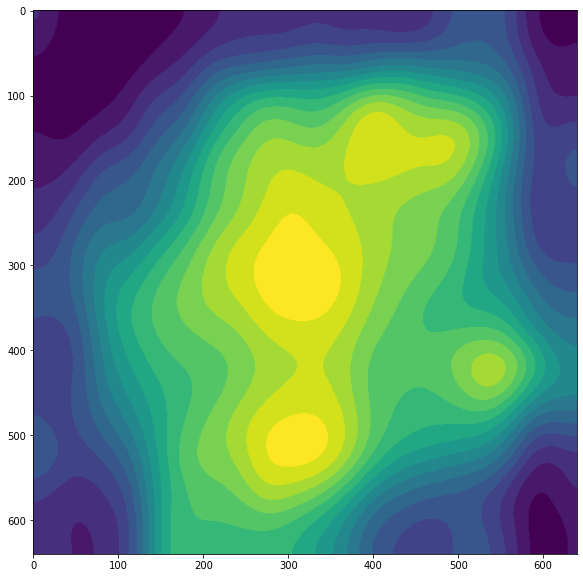

[(9, 13.290234788633587, 0.19911523622562322, 39780.0, 1.5, 1, 80, 4), (1, 13.677253217619684, 0.25609231892079826, 55335.0, 1.5, 1, 79, 4), (0, 15.328396518935373, 0.8841677211825314, 168120.0, 1.4117955086337866, 1, 78, 4), (35, 15.875243838427238, 1.1731234212267008, 175950.0, 1.624165274450806, 1, 77, 4), (80, 16.157470732792948, 1.0629585457459974, 322132.0, 1.4117955086337866, 1, 76, 4), (26, 16.353271196184366, 1.4172782740302843, 233665.0, 1.5743491774985174, 1, 75, 4), (72, 16.47216959303798, 0.8124711643048919, 566880.0, 1.4117955086337866, 1, 74, 4), (54, 16.49509996221923, 1.2611977702475943, 314756.0, 1.5743491774985174, 1, 73, 4), (78, 16.660963428082287, 1.4754765769667721, 299880.0, 1.5743491774985174, 1, 72, 4), (45, 16.81991994086665, 1.5917283867280414, 297755.0, 1.624165274450806, 1, 71, 4), (51, 16.85800891210088, 0.7713132317932117, 549160.0, 1.8705505632961241, 1, 70, 4), (75, 16.903710826585467, 1.583145952315843, 326570.0, 1.624165274450806, 1, 69, 4), (8, 16.9

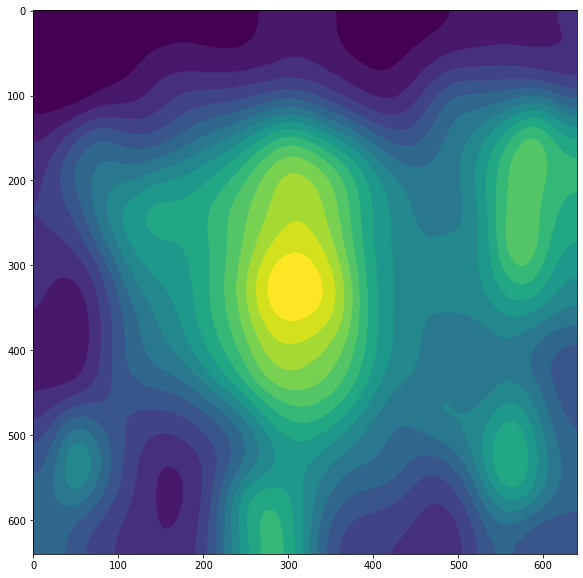

[(0, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (42, 2.8950250709279723, 0.0, 0.0, 1.8950250709279723, 1, 79, 4), (1, 14.12712258833228, 0.3364660572656016, 80070.0, 1.5, 1, 78, 4), (45, 14.827914472253381, 0.4619764786014581, 125715.0, 1.624165274450806, 1, 77, 4), (4, 15.365194822772832, 0.5946683140081591, 185130.0, 1.6417129487814521, 1, 76, 4), (5, 15.678354748066443, 0.6863807049006161, 235110.0, 1.624165274450806, 1, 75, 4), (52, 15.683024331132039, 0.888974661522309, 168753.0, 1.757858283255199, 1, 74, 4), (78, 16.1741154676802, 1.0771508290787477, 274475.0, 1.5743491774985174, 1, 73, 4), (7, 16.33887551149812, 1.2283382581933655, 299700.0, 1.5, 1, 72, 4), (9, 16.36830888245146, 1.4559540426824853, 245820.0, 1.5, 1, 71, 4), (8, 16.379071286094913, 1.1168549905798233, 380949.0, 1.4117955086337866, 1, 70, 4), (6, 16.491701261323744, 1.3898301981967174, 275825.0, 1.5743491774985174, 1, 69, 4), (73, 16.55087763868324, 1.5092796332495848, 279735.0, 1.5, 1, 68, 4), 

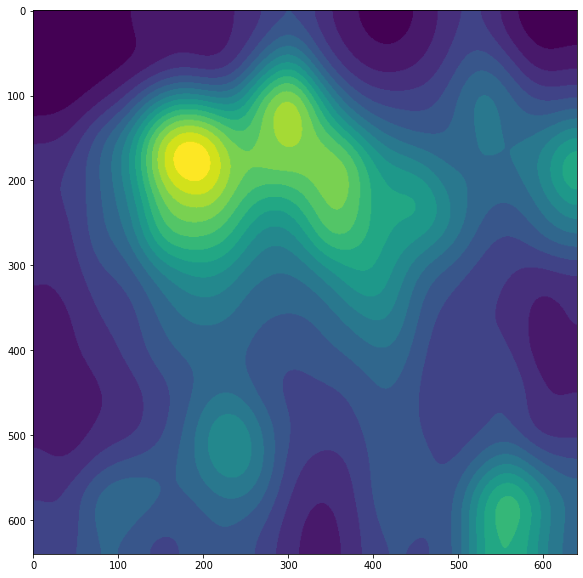

[(0, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (54, 11.420324731595768, 0.04661547091734337, 6630.0, 1.5743491774985174, 1, 79, 4), (61, 15.214929386915278, 0.5401436402122208, 159120.0, 1.6973718331752026, 1, 78, 4), (2, 15.59590485757158, 0.9332479453635302, 177781.0, 1.5743491774985174, 1, 77, 4), (53, 15.641885870602179, 0.8920340505804513, 184552.0, 1.624165274450806, 1, 76, 4), (1, 15.950561878341372, 1.0262537061695742, 248776.0, 1.5, 1, 75, 4), (9, 16.088479185791513, 1.3142106529485875, 214115.0, 1.5, 1, 74, 4), (45, 16.119920444832164, 0.8124550505161307, 322320.0, 1.624165274450806, 1, 73, 4), (25, 16.128630741216362, 0.7941021417852023, 307785.0, 1.6973718331752026, 1, 72, 4), (8, 16.156468226056685, 1.338909401953292, 244205.0, 1.4117955086337866, 1, 71, 4), (60, 16.364438629599046, 1.0457681212496557, 273102.0, 1.8010698775896221, 1, 70, 4), (58, 16.502849755539426, 0.8439951206308587, 349350.0, 1.8950250709279723, 1, 69, 4), (69, 16.588106627296774, 0.

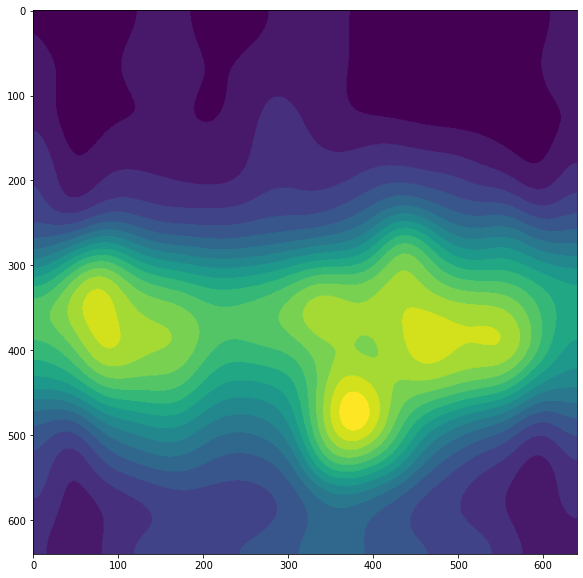

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (74, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (6, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 78, 4), (4, 2.641712948781452, 0.0, 0.0, 1.6417129487814521, 1, 77, 4), (16, 11.181456464521549, 0.037363203611607, 5100.0, 1.6070974421975235, 1, 76, 4), (80, 14.817157294362268, 0.5114688442504889, 146370.0, 1.4117955086337866, 1, 75, 4), (15, 15.083982450169804, 0.5067529936329933, 144330.0, 1.6973718331752026, 1, 74, 4), (0, 15.21433285244571, 0.6161828291478535, 196095.0, 1.4117955086337866, 1, 73, 4), (75, 15.644687456282524, 0.6768638733489792, 229500.0, 1.624165274450806, 1, 72, 4), (20, 15.748619850271327, 0.6563552337347075, 217770.0, 1.8010698775896221, 1, 71, 4), (72, 15.78471598371263, 0.999212759843848, 236501.0, 1.4117955086337866, 1, 70, 4), (78, 16.00800262801165, 1.0222916999026093, 245576.0, 1.5743491774985174, 1, 69, 4), (5, 16.046117944287527, 0.7914459696507827, 305745.0, 1.624165274450806, 1, 68, 4), (13, 1

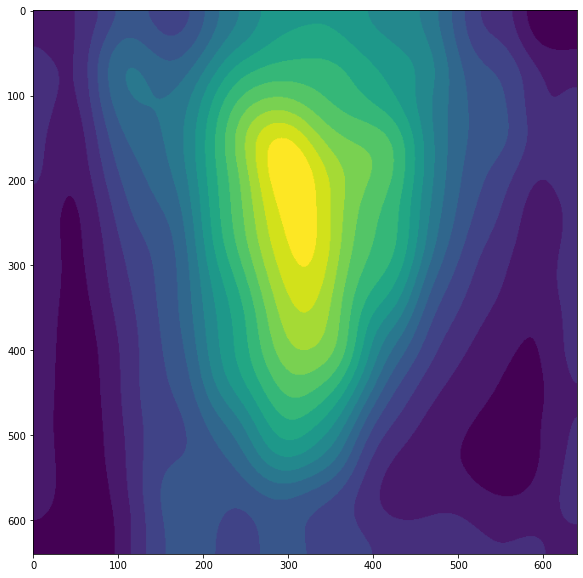

[(69, 14.375069212993438, 0.34647366376255545, 83385.0, 1.6973718331752026, 1, 80, 4), (72, 14.922851126278958, 0.5384609905532665, 158355.0, 1.4117955086337866, 1, 79, 4), (70, 15.813445896458695, 0.7297144630876367, 262140.0, 1.6070974421975235, 1, 78, 4), (18, 15.982221217637084, 0.7874241003704725, 302685.0, 1.5743491774985174, 1, 77, 4), (0, 16.218796461991808, 1.1812119002831838, 304306.0, 1.4117955086337866, 1, 76, 4), (44, 16.36716177821838, 0.8763125035147981, 380460.0, 1.6417129487814521, 1, 75, 4), (8, 16.38882767260805, 1.4272634367335555, 282030.0, 1.4117955086337866, 1, 74, 4), (63, 16.517400641415943, 0.9494195349048105, 473535.0, 1.5, 1, 73, 4), (54, 16.529412600209326, 0.935065051984507, 451350.0, 1.5743491774985174, 1, 72, 4), (75, 16.533768598439853, 1.0904987082007185, 369204.0, 1.624165274450806, 1, 71, 4), (35, 16.55066674743848, 0.928205838706869, 441660.0, 1.624165274450806, 1, 70, 4), (62, 16.56878358262814, 1.1583381017596928, 375531.0, 1.5743491774985174, 1, 

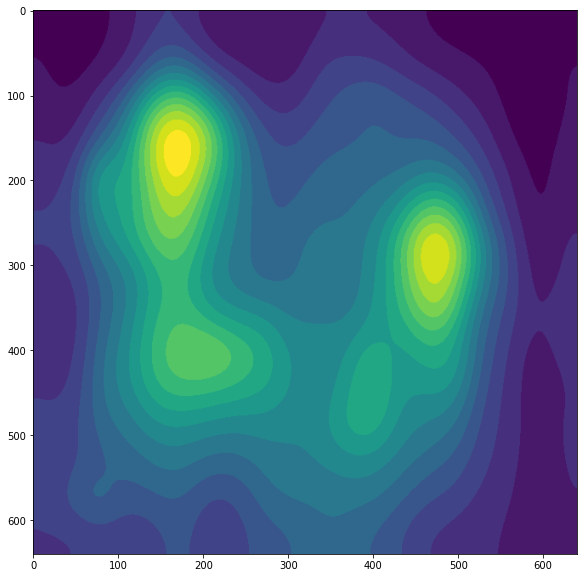

[(80, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (8, 10.619702102147958, 0.02758571874048561, 3570.0, 1.4117955086337866, 1, 79, 4), (0, 13.605435586807232, 0.25874898666265794, 56100.0, 1.4117955086337866, 1, 78, 4), (3, 14.777128839872177, 0.6490788451032907, 99100.0, 1.624165274450806, 1, 77, 4), (7, 14.833807843730586, 0.4935950517162183, 138720.0, 1.5, 1, 76, 4), (17, 15.460501097287514, 0.6599822814653948, 219810.0, 1.5, 1, 75, 4), (71, 15.511205326182822, 0.6742360058508821, 227970.0, 1.5, 1, 74, 4), (58, 15.845823401246196, 0.6572644090180566, 218280.0, 1.8950250709279723, 1, 73, 4), (4, 16.107909969653036, 1.057653029296737, 244885.0, 1.6417129487814521, 1, 72, 4), (73, 16.13912295349084, 1.0566433274525182, 291408.0, 1.5, 1, 71, 4), (62, 16.299798006935447, 0.8763125035147981, 380460.0, 1.5743491774985174, 1, 70, 4), (63, 16.348056236169818, 0.9086185980409246, 416415.0, 1.5, 1, 69, 4), (45, 16.371246942337716, 1.2058948503450948, 279620.0, 1.624165274450806

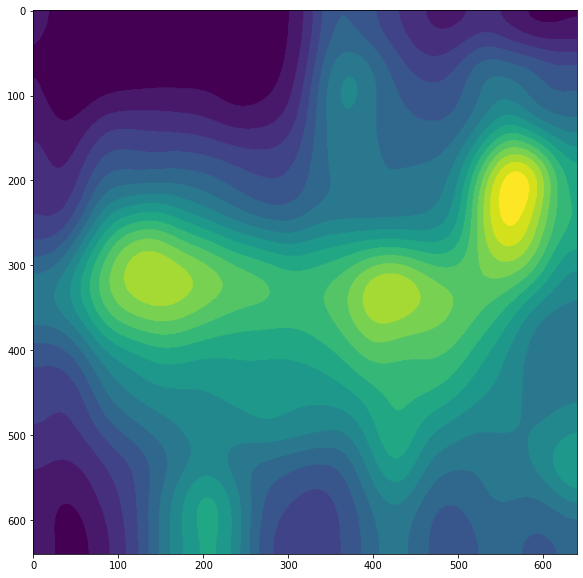

[(1, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (2, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (3, 2.6241652744508057, 0.0, 0.0, 1.624165274450806, 1, 78, 4), (0, 14.767428837499462, 0.49901178218491365, 141015.0, 1.4117955086337866, 1, 77, 4), (76, 15.265732334770378, 0.5680431499579708, 172125.0, 1.6417129487814521, 1, 76, 4), (53, 15.488071700592915, 1.0310737414253617, 137700.0, 1.624165274450806, 1, 75, 4), (9, 15.980324770512663, 1.0150929914639466, 259168.0, 1.5, 1, 74, 4), (62, 16.419933786872715, 0.9079857704149625, 415650.0, 1.5743491774985174, 1, 73, 4), (63, 16.560361282021596, 1.1809972846428283, 392136.0, 1.5, 1, 72, 4), (70, 16.667566948967337, 0.8177663649274127, 563940.0, 1.6070974421975235, 1, 71, 4), (79, 16.72554223272193, 1.0193249579243033, 543735.0, 1.5, 1, 70, 4), (18, 16.869164417625424, 1.5076589000460665, 357595.0, 1.5743491774985174, 1, 69, 4), (12, 16.880255497591175, 1.307260330017817, 367742.0, 1.757858283255199, 1, 68, 4), (24, 16.895968664998673, 

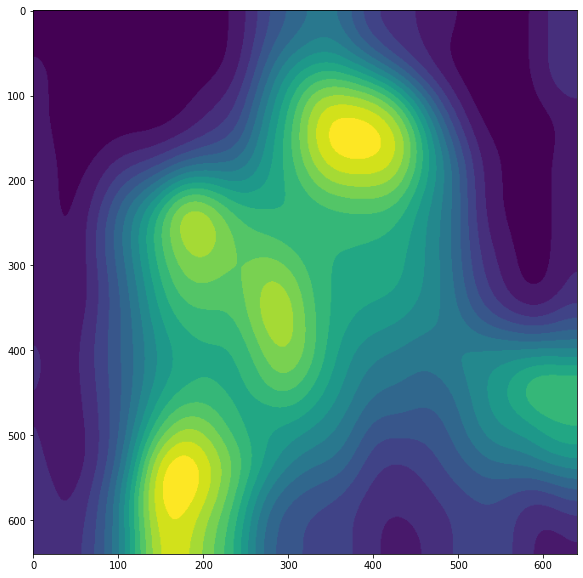

[(1, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (2, 2.5743491774985174, 0.0, 0.0, 1.5743491774985174, 1, 79, 4), (10, 10.95186388477012, 0.030914175174389536, 4080.0, 1.6070974421975235, 1, 78, 4), (7, 11.305243266865906, 0.04510389683927962, 6375.0, 1.5, 1, 77, 4), (0, 13.328675682715144, 0.21656132970840236, 44370.0, 1.4117955086337866, 1, 76, 4), (36, 15.110927472687852, 0.5276935334391538, 153510.0, 1.6417129487814521, 1, 75, 4), (54, 15.884456790798092, 0.7594351354325112, 282285.0, 1.5743491774985174, 1, 74, 4), (16, 15.911614638509974, 1.219341805589233, 177225.0, 1.6070974421975235, 1, 73, 4), (63, 16.042822038289387, 1.0270318934468181, 272608.0, 1.5, 1, 72, 4), (9, 16.068767902442776, 0.8330675061840151, 339660.0, 1.5, 1, 71, 4), (45, 16.146161827698595, 0.8198871014250659, 328440.0, 1.624165274450806, 1, 70, 4), (11, 16.255096390803068, 1.2866369419799613, 213435.0, 1.6973718331752026, 1, 69, 4), (79, 16.55963938586155, 0.6071610796201057, 695564.0, 1.5, 1, 68, 4), (72, 16.6428800411773

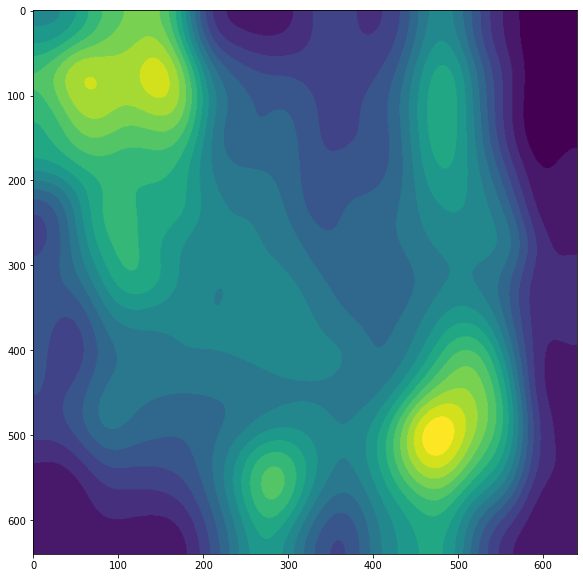

[(72, 12.122485637797519, 0.0918891400995851, 15045.0, 1.4117955086337866, 1, 80, 4), (41, 13.630467603791542, 0.18207517809013885, 35445.0, 1.9726549474122854, 1, 79, 4), (8, 14.552969916793602, 0.44717816829728463, 119850.0, 1.4117955086337866, 1, 78, 4), (80, 14.768809329180256, 0.8487492004584347, 99535.0, 1.4117955086337866, 1, 77, 4), (17, 15.192976218639178, 0.5864477034453908, 181050.0, 1.5, 1, 76, 4), (38, 16.437583507182275, 1.1285167927808666, 246235.0, 1.8950250709279723, 1, 75, 4), (45, 16.53793859732733, 1.1104395923984054, 363427.0, 1.624165274450806, 1, 74, 4), (73, 16.58535183827167, 0.9638988751687034, 499545.0, 1.5, 1, 73, 4), (21, 16.643559436649454, 1.0702480687330886, 328654.0, 1.8705505632961241, 1, 72, 4), (26, 16.707100567877237, 1.4376540436414518, 326145.0, 1.5743491774985174, 1, 71, 4), (5, 16.807584305429458, 0.8851227944523957, 596179.0, 1.624165274450806, 1, 70, 4), (54, 16.825458223735513, 1.3862839968863203, 386476.0, 1.5743491774985174, 1, 69, 4), (57,

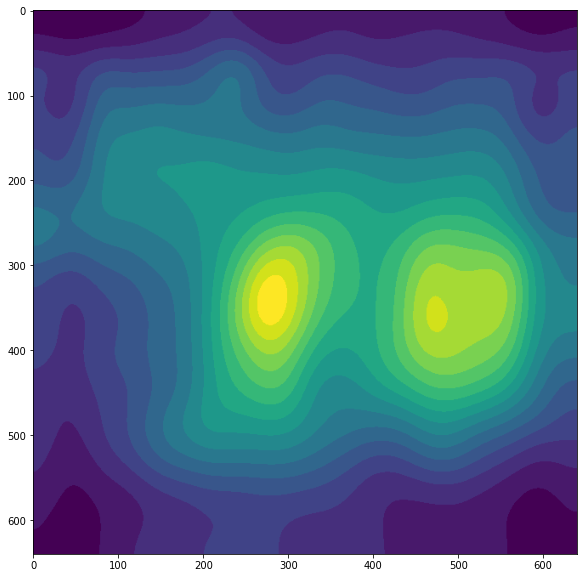

[(75, 12.579915456285114, 0.11042154347171226, 18870.0, 1.624165274450806, 1, 80, 4), (80, 14.455348021508746, 0.42464672436749884, 111180.0, 1.4117955086337866, 1, 79, 4), (78, 15.450293273549795, 0.6364124967774383, 206805.0, 1.5743491774985174, 1, 78, 4), (72, 15.509218331607737, 0.6986452152701339, 242505.0, 1.4117955086337866, 1, 77, 4), (74, 15.857610231149486, 0.7517410079986624, 276930.0, 1.5743491774985174, 1, 76, 4), (76, 16.273626580651364, 1.0511753497851002, 290901.0, 1.6417129487814521, 1, 75, 4), (54, 16.30411784935923, 0.37681593212073544, 629671.0, 1.5743491774985174, 1, 74, 4), (79, 16.579687377602674, 0.76510821973576, 605966.0, 1.5, 1, 73, 4), (9, 16.626578173473003, 1.4239512572144095, 328610.0, 1.5, 1, 72, 4), (17, 16.65331588736168, 1.079105477179883, 476494.0, 1.5, 1, 71, 4), (77, 16.713167054424993, 0.8299245792540354, 573250.0, 1.624165274450806, 1, 70, 4), (27, 16.73967452140734, 0.969849353001772, 511785.0, 1.624165274450806, 1, 69, 4), (0, 16.87194912746573

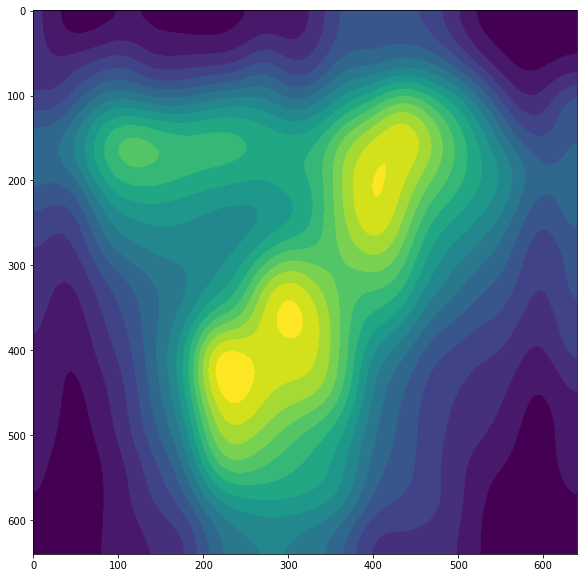

[(72, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (80, 9.058906095925296, 0.0072347534649740385, 765.0, 1.4117955086337866, 1, 79, 4), (8, 14.851699579178309, 0.5202143417345091, 150195.0, 1.4117955086337866, 1, 78, 4), (63, 15.981318872878505, 0.8083568172531685, 319005.0, 1.5, 1, 77, 4), (78, 16.09098998847242, 1.040201391257345, 262089.0, 1.5743491774985174, 1, 76, 4), (71, 16.15839097290813, 0.8580112996526004, 362355.0, 1.5, 1, 75, 4), (79, 16.53989500113307, 1.2954506333369689, 342643.0, 1.5, 1, 74, 4), (45, 16.560776621345404, 0.4669728659523821, 707603.0, 1.624165274450806, 1, 73, 4), (36, 16.6573483592334, 1.164044547985646, 381395.0, 1.6417129487814521, 1, 72, 4), (30, 16.779448108439023, 1.3083369512968668, 275145.0, 1.946057646725596, 1, 71, 4), (62, 16.858715355346295, 1.131904338019415, 515278.0, 1.5743491774985174, 1, 70, 4), (61, 16.926732204280487, 1.052510702358071, 527999.0, 1.6973718331752026, 1, 69, 4), (73, 16.946090196195392, 1.3842308228821096, 

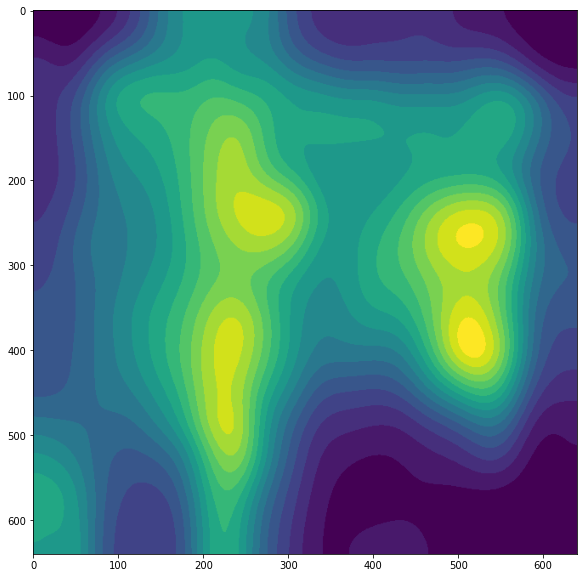

[(80, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (79, 2.5, 0.0, 0.0, 1.5, 1, 79, 4), (8, 15.162889128039984, 1.1094319905657684, 113739.0, 1.4117955086337866, 1, 78, 4), (71, 15.340646857216727, 1.0328154747053977, 134300.0, 1.5, 1, 77, 4), (23, 15.571211099571938, 0.5885140287778029, 182070.0, 1.8705505632961241, 1, 76, 4), (78, 16.032009978018113, 0.8016278069947056, 313650.0, 1.5743491774985174, 1, 75, 4), (0, 16.410444137234933, 1.6240829342135503, 236704.0, 1.4117955086337866, 1, 74, 4), (77, 16.41823111814588, 0.8946085458036159, 400095.0, 1.624165274450806, 1, 73, 4), (73, 16.46212824918812, 1.4893928984302403, 261120.0, 1.5, 1, 72, 4), (45, 16.508618973938166, 0.917832267301782, 427890.0, 1.624165274450806, 1, 71, 4), (68, 16.512820080393297, 1.0738668868072119, 321610.0, 1.757858283255199, 1, 70, 4), (5, 16.53163399512133, 1.4334321335546727, 261460.0, 1.624165274450806, 1, 69, 4), (24, 16.992743451303387, 1.336301147403922, 382840.0, 1.8010698775896221, 1, 6

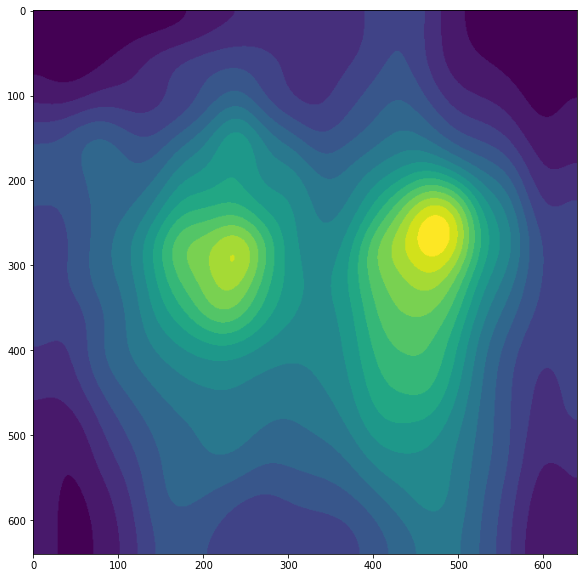

[(8, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 80, 4), (0, 2.4117955086337863, 0.0, 0.0, 1.4117955086337866, 1, 79, 4), (4, 12.709626869613322, 0.11993112840918946, 20910.0, 1.6417129487814521, 1, 78, 4), (80, 14.885125663632254, 0.7195784038617191, 127230.0, 1.4117955086337866, 1, 77, 4), (75, 15.820944114031283, 0.7269774762573853, 260355.0, 1.624165274450806, 1, 76, 4), (1, 16.00363317922192, 1.0848633562396983, 247402.0, 1.5, 1, 75, 4), (17, 16.019294613925936, 1.0200636678895167, 268131.0, 1.5, 1, 74, 4), (76, 16.056643607876453, 0.7894406918386583, 304215.0, 1.6417129487814521, 1, 73, 4), (36, 16.19048333738759, 1.0989479658688068, 255205.0, 1.6417129487814521, 1, 72, 4), (7, 16.302679081853185, 0.8968685224391166, 402645.0, 1.5, 1, 71, 4), (53, 16.30418506217714, 0.6073825123446571, 475745.0, 1.624165274450806, 1, 70, 4), (63, 16.37221182429846, 0.5398679497062063, 616827.0, 1.5, 1, 69, 4), (44, 16.529557862705694, 1.453263137581447, 251345.0, 1.6417129487814521, 1, 6

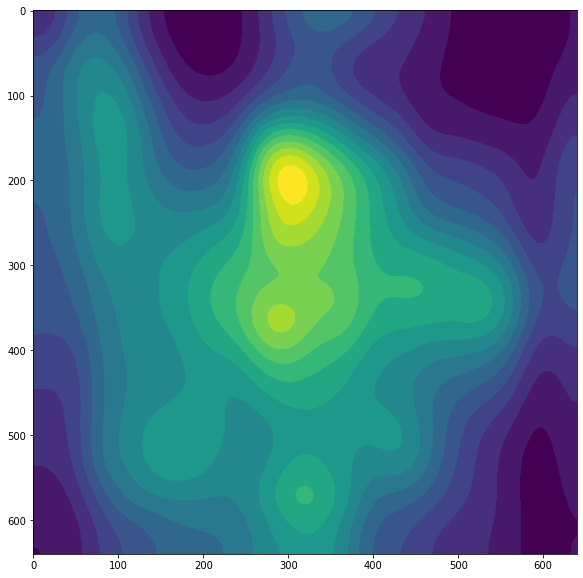

[(7, 2.5, 0.0, 0.0, 1.5, 1, 80, 4), (80, 15.20894983306812, 0.6147086095353156, 195330.0, 1.4117955086337866, 1, 79, 4), (8, 15.42766660197887, 0.6755516861278612, 228735.0, 1.4117955086337866, 1, 78, 4), (66, 15.781473077226433, 0.6777367287501841, 230010.0, 1.757858283255199, 1, 77, 4), (2, 15.856361883904778, 1.197797008654973, 177055.0, 1.5743491774985174, 1, 76, 4), (16, 16.354377816366675, 0.8821862628084067, 386580.0, 1.6070974421975235, 1, 75, 4), (36, 16.47082435993761, 1.3901429228690938, 252450.0, 1.6417129487814521, 1, 74, 4), (67, 16.599262816279246, 1.1412289908201252, 320895.0, 1.7791645796604998, 1, 73, 4), (79, 16.670534531056497, 1.1978714179525995, 430483.0, 1.5, 1, 72, 4), (72, 16.75262660226631, 1.0980658903759006, 563975.0, 1.4117955086337866, 1, 71, 4), (71, 16.762656211607982, 0.9929768866085175, 579360.0, 1.5, 1, 70, 4), (62, 16.79015600904881, 1.0131730800826966, 541790.0, 1.5743491774985174, 1, 69, 4), (18, 16.859067191780316, 1.4071636995794565, 391427.0, 1.

KeyboardInterrupt: 

In [5]:
from time import time
import deepgaze_pytorch

plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
plt.tight_layout()

generators = ['deepgaze']

BATCH_SIZE = 8

DEVICE = 'cuda'  # Use GPU if available
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

# Split the images with masks into batches with the image names as keys and the images as values
image_batches = [{k: imgs[k] for k in list(masks.keys())[i:i+BATCH_SIZE]} for i in range(0, len(masks), BATCH_SIZE)]

seg_dim = 9
saliency_maps = {}
sara_heatmaps = {}
sara_lists = {}

sara.WEIGHTS = (1, 1, 1, 1)

c = 0

for batch in image_batches:
    start = time()

    for im in batch:
        if im not in saliency_maps:
            saliency_maps[im] = {}
            sara_heatmaps[im] = {}
            sara_lists[im] = {}

        

    for generator in generators:
        temp_saliency_maps = sara.return_saliency_batch(batch.values(), generator=generator, deepgaze_model=model, DEVICE=DEVICE, BATCH_SIZE=BATCH_SIZE)
        
    sara.reset()

    for i, im in enumerate(batch):
        saliency_maps[im][generator] = temp_saliency_maps[i]
        plt.figure()
        plt.imshow(temp_saliency_maps[i])
        plt.show()
        sara_heatmaps[im][generator], sara_lists[im][generator] = sara.return_sara(cv2.cvtColor(imgs[im].copy(), cv2.COLOR_RGB2BGR), seg_dim, saliency_map=saliency_maps[im][generator])
        print(sara_lists[im][generator])
        # plt.figure()
        # plt.subplot(121)
        # plt.imshow(saliency_maps[im][generator], cmap='gray')
        # plt.subplot(122)
        # plt.imshow(cv2.cvtColor(sara_heatmaps[im][generator], cv2.COLOR_BGR2RGB))
        # plt.show()
        # sara.reset()

    c += 1

    print(f'Batch {c} of {len(image_batches)} complete')

**Old SaRa**

In [72]:
from time import time
import deepgaze_pytorch

plt.rcParams['figure.figsize'] = [20, 10]
plt.figure()
plt.tight_layout()

generators = ['itti']

BATCH_SIZE = 8

DEVICE = 'cpu'  # Use GPU if available
# model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

# Split the images with masks into batches with the image names as keys and the images as values
# image_batches = [{k: imgs[k] for k in list(masks.keys())[i:i+BATCH_SIZE]} for i in range(0, len(masks), BATCH_SIZE)]

seg_dim = 9
saliency_maps = {}
sara_heatmaps = {}
sara_lists = {}

sara.WEIGHTS = (1, 1, 1, 1)

c = 0

for im in imgs:
    start = time()

    if im not in saliency_maps:
        saliency_maps[im] = {}
        sara_heatmaps[im] = {}
        sara_lists[im] = {}

    for generator in generators:
        # saliency_maps[im][generator] = sara.return_saliency(imgs[im], generator=generator)
        # sara_heatmaps[im][generator], sara_lists[im][generator] = sara.return_sara(cv2.cvtColor(imgs[im].copy(), cv2.COLOR_RGB2BGR), seg_dim, saliency_map=saliency_maps[im][generator])
        # sara_heatmaps[im][generator], sara_lists[im][generator] = sara_old.returnSARA(cv2.cvtColor(imgs[im].copy(), cv2.COLOR_RGB2BGR))

        sara_heatmaps[im][generator], sara_lists[im][generator] = sara_old.returnSARA(cv2.cvtColor(imgs[im].copy(), cv2.COLOR_RGB2BGR))
        print(sara_lists[im][generator])


    c += 1

    # print(f'Image {c} of {len(imgs)} complete')

[(57, 0, 4), (31, 1, 4), (40, 2, 4), (34, 3, 4), (48, 4, 4), (39, 5, 4), (25, 6, 4), (16, 7, 4), (22, 8, 4), (28, 9, 4), (30, 10, 4), (43, 11, 4), (58, 12, 4), (44, 13, 4), (29, 14, 4), (66, 15, 4), (37, 16, 4), (19, 17, 4), (65, 18, 4), (49, 19, 4), (67, 20, 3), (13, 21, 3), (4, 22, 3), (26, 23, 3), (56, 24, 3), (64, 25, 3), (75, 26, 3), (3, 27, 3), (5, 28, 3), (50, 29, 3), (20, 30, 3), (35, 31, 3), (33, 32, 3), (59, 33, 3), (21, 34, 3), (2, 35, 3), (38, 36, 3), (6, 37, 3), (55, 38, 3), (60, 39, 3), (17, 40, 2), (63, 41, 2), (15, 42, 2), (69, 43, 2), (36, 44, 2), (70, 45, 2), (42, 46, 2), (71, 47, 2), (61, 48, 2), (27, 49, 2), (1, 50, 2), (24, 51, 2), (68, 52, 2), (62, 53, 2), (0, 54, 2), (12, 55, 2), (76, 56, 2), (23, 57, 2), (41, 58, 2), (54, 59, 2), (18, 60, 1), (77, 61, 1), (32, 62, 1), (11, 63, 1), (45, 64, 1), (14, 65, 1), (46, 66, 1), (78, 67, 1), (10, 68, 1), (7, 69, 1), (51, 70, 1), (47, 71, 1), (79, 72, 1), (9, 73, 1), (74, 74, 1), (53, 75, 1), (80, 76, 1), (72, 77, 1), (73,

/home/matthewkenely/Programming/Assignments/ICT3909 Final Year Project in Artificial Intelligence/ICT3909/optimisations/saliency-generator/saraRC1Old.py:115: RuntimeWarning: overflow encountered in double_scalars
  entropy = entropy * wt * dw


[(49, 0, 4), (58, 1, 4), (59, 2, 4), (50, 3, 4), (40, 4, 4), (31, 5, 4), (54, 6, 4), (46, 7, 4), (12, 8, 4), (30, 9, 4), (63, 10, 4), (39, 11, 4), (5, 12, 4), (3, 13, 4), (56, 14, 4), (47, 15, 4), (72, 16, 4), (38, 17, 4), (68, 18, 4), (10, 19, 4), (67, 20, 3), (6, 21, 3), (2, 22, 3), (70, 23, 3), (45, 24, 3), (69, 25, 3), (11, 26, 3), (29, 27, 3), (1, 28, 3), (79, 29, 3), (37, 30, 3), (57, 31, 3), (62, 32, 3), (55, 33, 3), (77, 34, 3), (60, 35, 3), (48, 36, 3), (78, 37, 3), (76, 38, 3), (80, 39, 3), (41, 40, 2), (65, 41, 2), (73, 42, 2), (51, 43, 2), (71, 44, 2), (36, 45, 2), (19, 46, 2), (27, 47, 2), (7, 48, 2), (66, 49, 2), (17, 50, 2), (18, 51, 2), (75, 52, 2), (35, 53, 2), (28, 54, 2), (21, 55, 2), (64, 56, 2), (9, 57, 2), (74, 58, 2), (43, 59, 2), (26, 60, 1), (16, 61, 1), (0, 62, 1), (20, 63, 1), (53, 64, 1), (52, 65, 1), (34, 66, 1), (8, 67, 1), (44, 68, 1), (4, 69, 1), (15, 70, 1), (22, 71, 1), (61, 72, 1), (42, 73, 1), (13, 74, 1), (33, 75, 1), (32, 76, 1), (23, 77, 1), (14, 

/home/matthewkenely/Programming/Assignments/ICT3909 Final Year Project in Artificial Intelligence/ICT3909/optimisations/saliency-generator/saraRC1Old.py:113: RuntimeWarning: overflow encountered in double_scalars
  entropy += entropy + tprob * math.log(1/tprob, 2)


[(50, 0, 4), (53, 1, 4), (3, 2, 4), (62, 3, 4), (15, 4, 4), (59, 5, 4), (60, 6, 4), (22, 7, 4), (13, 8, 4), (58, 9, 4), (57, 10, 4), (51, 11, 4), (47, 12, 4), (56, 13, 4), (49, 14, 4), (45, 15, 4), (52, 16, 4), (55, 17, 4), (46, 18, 4), (54, 19, 4), (48, 20, 3), (38, 21, 3), (64, 22, 3), (25, 23, 3), (5, 24, 3), (65, 25, 3), (36, 26, 3), (4, 27, 3), (63, 28, 3), (6, 29, 3), (32, 30, 3), (70, 31, 3), (8, 32, 3), (24, 33, 3), (1, 34, 3), (37, 35, 3), (23, 36, 3), (27, 37, 3), (71, 38, 3), (35, 39, 3), (80, 40, 2), (44, 41, 2), (28, 42, 2), (20, 43, 2), (68, 44, 2), (14, 45, 2), (31, 46, 2), (72, 47, 2), (73, 48, 2), (33, 49, 2), (0, 50, 2), (16, 51, 2), (41, 52, 2), (18, 53, 2), (19, 54, 2), (40, 55, 2), (79, 56, 2), (2, 57, 2), (43, 58, 2), (29, 59, 2), (10, 60, 1), (11, 61, 1), (17, 62, 1), (78, 63, 1), (67, 64, 1), (7, 65, 1), (39, 66, 1), (61, 67, 1), (12, 68, 1), (34, 69, 1), (42, 70, 1), (30, 71, 1), (21, 72, 1), (66, 73, 1), (9, 74, 1), (26, 75, 1), (69, 76, 1), (77, 77, 1), (75, 

KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

In [6]:
old = False

if old:
    subdirectory = 'old'
else:
    subdirectory = 'new'

In [7]:
# Save to .h5
import h5py

with h5py.File('./experiments/' + str(experiment) + '/' + subdirectory + '/saliency_maps_' + str(experiment) + '.h5', 'w') as hf:
    for file_name in saliency_maps:
        for generator in saliency_maps[file_name]:
            hf.create_dataset(f'{file_name}/{generator}', data=saliency_maps[file_name][generator])

with h5py.File('./experiments/' + str(experiment) + '/' + subdirectory + '/sara_heatmaps_' + str(experiment) + '.h5', 'w') as hf:
    for file_name in sara_heatmaps:
        for generator in sara_heatmaps[file_name]:
            hf.create_dataset(f'{file_name}/{generator}', data=sara_heatmaps[file_name][generator])

with h5py.File('./experiments/' + str(experiment) + '/' + subdirectory + '/sara_lists_' + str(experiment) + '.h5', 'w') as hf:
    for file_name in sara_lists:
        for generator in sara_lists[file_name]:
            hf.create_dataset(f'{file_name}/{generator}', data=sara_lists[file_name][generator])

In [7]:
# Load from .h5
import h5py

saliency_maps = {}

with h5py.File('./experiments/' + str(experiment) + '/' + subdirectory + '/saliency_maps_' + str(experiment) + '.h5', 'r') as hf:
    for file_name in hf:
        saliency_maps[file_name] = {}
        for generator in hf[file_name]:
            saliency_maps[file_name][generator] = hf[f'{file_name}/{generator}'][:]

sara_heatmaps = {}

with h5py.File('./experiments/' + str(experiment) + '/' + subdirectory + '/sara_heatmaps_' + str(experiment) + '.h5', 'r') as hf:
    for file_name in hf:
        sara_heatmaps[file_name] = {}
        for generator in hf[file_name]:
            sara_heatmaps[file_name][generator] = hf[f'{file_name}/{generator}'][:]

sara_lists = {}

with h5py.File('./experiments/' + str(experiment) + '/' + subdirectory + '/sara_lists_' + str(experiment) + '.h5', 'r') as hf:
    for file_name in hf:
        sara_lists[file_name] = {}
        for generator in hf[file_name]:
            sara_lists[file_name][generator] = hf[f'{file_name}/{generator}'][:]

**<h2>Mask Ranking</h2>**

In [56]:
T = 0

In [57]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

In [58]:
# For each segment, check which mask falls under that segment using MRn = rank(Gi); (Gi interesect Mn) > T
mask_segments = {}

if old:
    generator = 'itti'
else:
    generator = 'deepgaze'
    

for sara_list in sara_lists:
    for segment in sara_lists[sara_list][generator]:
        if sara_list not in mask_segments:
            mask_segments[sara_list] = {}

        # Convert index to coordinates, extract segment from heatmap
        shape = sara_heatmaps[sara_list][generator].shape[0:2]
        if old:
            x1, y1, x2, y2 = index_to_coordinates(segment[0], seg_dim, shape)
        else:
            x1, y1, x2, y2 = index_to_coordinates(segment[6], seg_dim, shape)

        # print(x1, y1, x2, y2)

        if sara_list in list(masks.keys()):
            # Find the best matching mask
            best_iou = 0
            best_mask = None
            
            for m in masks[sara_list]:
                if m not in mask_segments[sara_list]:
                    mask_segments[sara_list][m] = []

                # Extract mask from masks
                mask = masks[sara_list][m][y1:y2, x1:x2]

                # Calculate intersection over union
                intersection = np.sum(mask > 0)
                union = np.sum(mask > 0) + np.sum(mask == 0)
                iou = intersection / union

                if iou > best_iou:
                    best_iou = iou
                    best_mask = m
                elif iou > 0:
                    mask_segments[sara_list][m].append(segment)

            if best_mask is not None:
                mask_segments[sara_list][best_mask].append(segment)


            # Check the masks which are not best_mask, if they will not be empty after removing the current segment, do so
            for m in mask_segments[sara_list]:
                if m != best_mask:
                    if len(mask_segments[sara_list][m]) > 1:
                        mask_segments[sara_list][m].pop()

        # Sort mask_segments[sara_list]


    # If there are empty masks, remove them and remove the corresponding mask in gt_ranks and gt_masks
    for m in list(mask_segments[sara_list].keys()):
        if len(mask_segments[sara_list][m]) == 0:
            del mask_segments[sara_list][m]
            del gt_masks[sara_list][m]

            # Find index of key
            for i, key in enumerate(gt_ranks[sara_list]):
                if key == m:
                    break
            # del gt_ranks[sara_list][i]
            gt_ranks[sara_list].pop(i)

In [59]:
# For each mask, find the segment with the lowest rank
mask_segments_min = {}

for sara_list in mask_segments:
    for m in mask_segments[sara_list]:
        # mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])[0]
        if sara_list not in mask_segments_min:
            mask_segments_min[sara_list] = {}
        
        if old:
            mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[1])
        else:
            mask_segments_min[sara_list][m] = min(mask_segments[sara_list][m], key=lambda x: x[0])
            

In [60]:
sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][0])

[('3', (6, -inf, 0.0, 0.0, 1.5743491774985174, 1, 76, 4)),
 ('0', (7, -inf, 0.0, 0.0, 1.5, 1, 77, 4)),
 ('1',
  (16,
   13.49689359481922,
   0.2127341704130076,
   43350.0,
   1.6070974421975235,
   1,
   74,
   4)),
 ('2',
  (51,
   17.509783658477,
   1.808570521187902,
   373496.0,
   1.8705505632961241,
   1,
   41,
   3)),
 ('4', (56, -inf, 0.0, 0.0, 1.8010698775896221, 1, 80, 4))]

In [61]:
gt_ranks[sara_list].items()

dict_items([(0, 1), (1, 2), (2, 3), (3, 5), (4, 4)])

In [62]:
mask_segments_min

{'COCO_val2014_000000000192': {'0': (55,
   16.16909354329787,
   1.0818993614185612,
   240343.0,
   1.6973718331752026,
   1,
   67,
   4),
  '1': (10, -inf, 0.0, 0.0, 1.6070974421975235, 1, 79, 4),
  '2': (7, -inf, 0.0, 0.0, 1.5, 1, 78, 4),
  '3': (75,
   13.067316593284469,
   0.15695564531198564,
   29325.0,
   1.624165274450806,
   1,
   72,
   4)},
 'COCO_val2014_000000000387': {'0': (4,
   17.401836586895335,
   1.763947260959938,
   440725.0,
   1.6417129487814521,
   1,
   43,
   3),
  '1': (67,
   17.716865244437933,
   1.4673106323122074,
   708135.0,
   1.7791645796604998,
   1,
   34,
   2)},
 'COCO_val2014_000000000520': {'0': (10,
   18.128498144112307,
   2.049648862622694,
   709100.0,
   1.6070974421975235,
   1,
   31,
   2),
  '1': (25,
   18.454519293848143,
   2.436197193786494,
   609839.0,
   1.6973718331752026,
   1,
   21,
   2),
  '10': (18,
   17.75923627773751,
   2.314457771612135,
   388648.0,
   1.5743491774985174,
   1,
   42,
   3),
  '2': (46,
   18.

In [63]:
sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][1])

[('0', (7, -inf, 0.0, 0.0, 1.5, 1, 77, 4)),
 ('3', (6, -inf, 0.0, 0.0, 1.5743491774985174, 1, 76, 4)),
 ('4', (56, -inf, 0.0, 0.0, 1.8010698775896221, 1, 80, 4)),
 ('1',
  (16,
   13.49689359481922,
   0.2127341704130076,
   43350.0,
   1.6070974421975235,
   1,
   74,
   4)),
 ('2',
  (51,
   17.509783658477,
   1.808570521187902,
   373496.0,
   1.8705505632961241,
   1,
   41,
   3))]

In [71]:
sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][0])

[('3', (6, -inf, 0.0, 0.0, 1.5743491774985174, 1, 76, 4)),
 ('0', (7, -inf, 0.0, 0.0, 1.5, 1, 77, 4)),
 ('1',
  (16,
   13.49689359481922,
   0.2127341704130076,
   43350.0,
   1.6070974421975235,
   1,
   74,
   4)),
 ('2',
  (51,
   17.509783658477,
   1.808570521187902,
   373496.0,
   1.8705505632961241,
   1,
   41,
   3)),
 ('4', (56, -inf, 0.0, 0.0, 1.8010698775896221, 1, 80, 4))]

In [69]:
mask_ranks = {}

for sara_list in mask_segments_min:
    mask_ranks[sara_list] = {}

    if old:
        sorted_ranks = sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][1])
    else:
        sorted_ranks = sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][0])


    for i in range(len(sorted_ranks)):
        mask_ranks[sara_list][sorted_ranks[i][0]] = i

    # Sort mask_ranks[sara_list] by object
    mask_ranks[sara_list] = {k: v for k, v in sorted(mask_ranks[sara_list].items(), key=lambda item: item[0])}

In [65]:
sara_lists['COCO_val2014_000000549427']

{'deepgaze': [(7, -inf, 0.0, 0.0, 1.5, 1, 80, 4),
  (6,
   11.199072695750415,
   0.03893753537004896,
   5355.0,
   1.5743491774985174,
   1,
   79,
   4),
  (8,
   13.642909610687015,
   0.2649005394133981,
   57885.0,
   1.4117955086337866,
   1,
   78,
   4),
  (45,
   15.31906623656538,
   0.5869649871529067,
   181305.0,
   1.624165274450806,
   1,
   77,
   4),
  (17, 15.610584498617277, 0.7023876689969687, 244800.0, 1.5, 1, 76, 4),
  (69,
   15.834327341584613,
   0.9059268703422626,
   205054.0,
   1.6973718331752026,
   1,
   75,
   4),
  (14,
   16.114045185666,
   0.7726371853126341,
   291720.0,
   1.757858283255199,
   1,
   74,
   4),
  (78,
   16.137944850976478,
   1.097800711893076,
   259314.0,
   1.5743491774985174,
   1,
   73,
   4),
  (54,
   16.194259267347366,
   0.8473595403628071,
   352410.0,
   1.5743491774985174,
   1,
   72,
   4),
  (18,
   16.24145100056169,
   0.8604085546507916,
   364650.0,
   1.5743491774985174,
   1,
   71,
   4),
  (63, 16.3018207

In [45]:
sara_lists['COCO_val2014_000000549427']

{'deepgaze': array([[7.00000000e+00,           -inf, 0.00000000e+00, 0.00000000e+00,
         1.50000000e+00, 1.00000000e+00, 8.00000000e+01, 4.00000000e+00],
        [6.00000000e+00, 1.11990727e+01, 3.89375354e-02, 5.35500000e+03,
         1.57434918e+00, 1.00000000e+00, 7.90000000e+01, 4.00000000e+00],
        [8.00000000e+00, 1.36429096e+01, 2.64900539e-01, 5.78850000e+04,
         1.41179551e+00, 1.00000000e+00, 7.80000000e+01, 4.00000000e+00],
        [4.50000000e+01, 1.53190662e+01, 5.86964987e-01, 1.81305000e+05,
         1.62416527e+00, 1.00000000e+00, 7.70000000e+01, 4.00000000e+00],
        [1.70000000e+01, 1.56105845e+01, 7.02387669e-01, 2.44800000e+05,
         1.50000000e+00, 1.00000000e+00, 7.60000000e+01, 4.00000000e+00],
        [6.90000000e+01, 1.58343273e+01, 9.05926870e-01, 2.05054000e+05,
         1.69737183e+00, 1.00000000e+00, 7.50000000e+01, 4.00000000e+00],
        [1.40000000e+01, 1.61140452e+01, 7.72637185e-01, 2.91720000e+05,
         1.75785828e+00, 1.000000

In [35]:
mask_segments_min['COCO_val2014_000000549427']

{'0': array([ 7. , -inf,  0. ,  0. ,  1.5,  1. , 80. ,  4. ]),
 '1': array([7.30000000e+01, 1.74101918e+01, 1.95224088e+00, 4.24196000e+05,
        1.50000000e+00, 1.00000000e+00, 4.60000000e+01, 3.00000000e+00]),
 '2': array([1.70000000e+01, 1.56105845e+01, 7.02387669e-01, 2.44800000e+05,
        1.50000000e+00, 1.00000000e+00, 7.60000000e+01, 4.00000000e+00]),
 '5': array([1.50000000e+01, 1.76125250e+01, 1.39609639e+00, 7.43450000e+05,
        1.69737183e+00, 1.00000000e+00, 4.10000000e+01, 3.00000000e+00]),
 '6': array([7.20000000e+01, 1.69085793e+01, 1.14696934e+00, 6.27698000e+05,
        1.41179551e+00, 1.00000000e+00, 5.60000000e+01, 3.00000000e+00]),
 '9': array([6.20000000e+01, 1.72769564e+01, 1.56160858e+00, 5.09405000e+05,
        1.57434918e+00, 1.00000000e+00, 4.80000000e+01, 3.00000000e+00])}

**<h2>Spearman Correlation (Metric for Ranks)</h2>**

In [15]:
def get_norm_spr(spr_value):
    r_min = -1
    r_max = 1

    norm_spr = (spr_value - r_min) / (r_max - r_min)

    return norm_spr

Average SPR: 0.5289256902298204


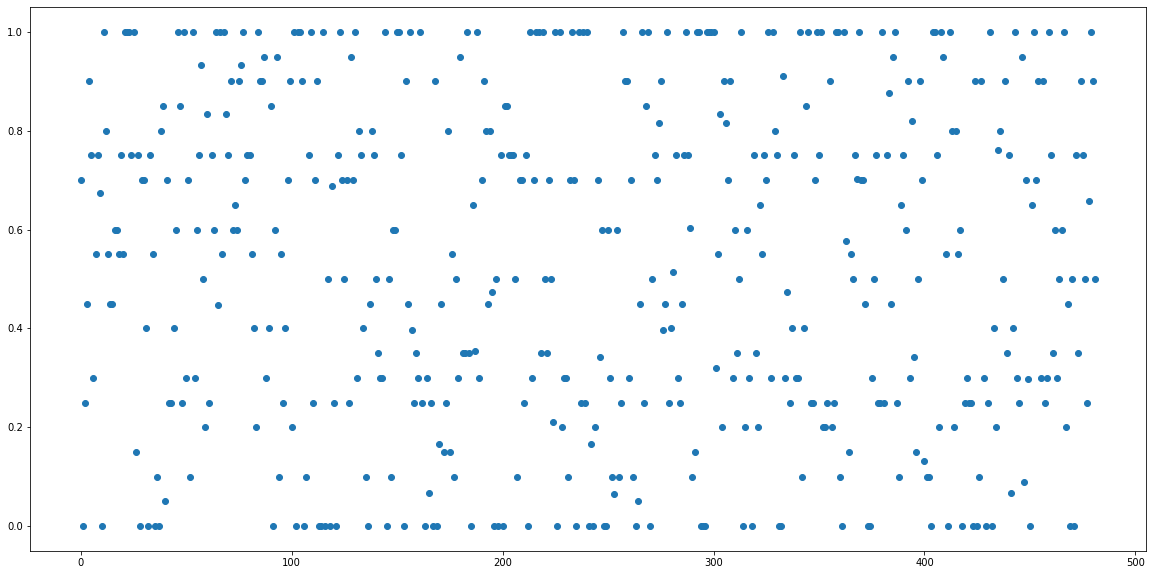

In [70]:
import scipy.stats as sc

all_spr = []

for sara_list in mask_ranks:
    # print(f'PR: {list(mask_ranks[sara_list].values())}\nGT: {list(gt_ranks[sara_list].values())}')
    spr = sc.spearmanr(list(mask_ranks[sara_list].values()), list(gt_ranks[sara_list].values())[:len(list(mask_ranks[sara_list].values()))])
    if not np.isnan(spr.correlation):
        all_spr.append(get_norm_spr(spr.correlation))
        # print(f'SPR: {spr.correlation}')

print(f'Average SPR: {np.mean(all_spr)}')

# Plot sprs
plt.figure(figsize=(20, 10))
plt.plot(all_spr, marker='o', linestyle='None')
plt.show()


In [18]:
len(all_spr)

482

In [15]:
# Dictionary: image: spr
sprs = {}

for sara_list in mask_ranks:
    spr = sc.spearmanr(list(mask_ranks[sara_list].values()), list(gt_ranks[sara_list].values())[:len(list(mask_ranks[sara_list].values()))])
    if not np.isnan(spr.correlation):
        sprs[sara_list] = get_norm_spr(spr.correlation)

# Sort sprs by value descending
sprs = {k: v for k, v in sorted(sprs.items(), key=lambda item: item[1], reverse=True)}

len_ = len(masks)

# Save len_ in txt file
with open('./experiments/' + str(experiment) + '/len_' + str(experiment) + '.txt', 'w') as f:
    f.write(str(len_))

In [75]:
# Get all sprs with value > 0.7
sprs_07 = {k: v for k, v in sprs.items() if v > 0.7}

for sara_list in mask_segments_min:
    mask_ranks[sara_list] = {}
    # Extract the ranks and sort them by the third value in each tuple
    sorted_ranks = sorted(mask_segments_min[sara_list].items(), key=lambda x: x[1][1])

    for i in range(len(sorted_ranks)):
        mask_ranks[sara_list][sorted_ranks[i][0]] = i

    # Sort mask_ranks[sara_list] by object
    mask_ranks[sara_list] = {k: v for k, v in sorted(mask_ranks[sara_list].items(), key=lambda item: item[0])}

In [16]:
# Save to .h5
import h5py

with h5py.File('./experiments/' + str(experiment) + '/' + subdirectory + '/sprs_' + str(experiment) + '.h5', 'w') as hf:
    for file_name in sprs:
        hf.create_dataset(f'{file_name}', data=sprs[file_name])

In [45]:
# Load from .h5
import h5py

sprs = {}

with h5py.File('./experiments/' + str(experiment) + '/' + subdirectory + '/sprs_' + str(experiment) + '.h5', 'r') as hf:
    for file_name in hf:
        sprs[file_name] = hf[file_name][:]

        # Convert list into dict with keys as integers
        sprs[file_name] = {i: spr for i, spr in enumerate(sprs[file_name])}

ValueError: Illegal slicing argument for scalar dataspace

**<h2>Mean Absolute Error</h2>**

In [43]:
def mae(pred, gt):
    return np.mean(np.abs(pred - gt))

In [45]:
all_mae = 0

from time import sleep

for sara_list in masks:
    for mask in masks[sara_list]:
        # print(masks[sara_list][mask] - gt_masks[sara_list][mask])
        pred = masks[sara_list][mask]
        pred = np.array(pred, dtype=np.uint8)
        pred = cv2.threshold(pred, 0.5, 1, cv2.THRESH_BINARY)[1]

        gt = gt_masks[sara_list][mask]
        gt = np.array(gt, dtype=np.uint8)
        gt = cv2.threshold(gt, 0.5, 1, cv2.THRESH_BINARY)[1]

        temp_mae = mae(pred, gt)

        # Print iou
        intersection = np.logical_and(pred, gt)
        union = np.logical_or(pred, gt)
        iou_score = np.sum(intersection) / np.sum(union)
        # print(f'IOU: {iou_score}')

        # plt.figure()
        # plt.subplot(131)
        # plt.imshow(pred)
        # plt.subplot(132)
        # plt.imshow(gt)
        # plt.subplot(133)
        # plt.imshow(pred - gt)
        # plt.show()
        all_mae += temp_mae
        # print()
        # break

print(f'Average /mae: {all_mae / len(masks)}')

Average /mae: 0.0
